# Optymalizacja reguły PPMF 

In [84]:
library(tidyverse)
library(magrittr)
library(furrr)
library(here)
library(gghighlight)
options(repr.plot.width=20, repr.plot.height=10)

In [85]:
source(here::here("src", "alg-exp", "cma-es-csa.R"))
source(here::here("src", "alg-exp", "cma-es-expth.R"))
source(here::here("src", "exp-utils.R"))
source(here::here("src", "data-utils.R"))
source(here::here("src", "plot-funcs.R"))
source(here::here("src", "eval-funcs.R"))

In [86]:
eval_func = 
    . %>% crossprod(.) 

# "Fabryka" CMA-ESów
expth_factory = function(d_params, p_targets) {
    expand.grid(
        d_param = d_params,
        p_target = p_targets
    ) %>%
    purrr::pmap(function(d_param, p_target) {
     purrr::partial(cma_es_expth, d_param = d_param, p_target = p_target)    
    })
}

In [87]:
d_params = 
    c(0.1, 0.3, 0.5, 0.8, 0.9, 2)

p_targets = 
    c(0.1, 0.25, 0.5, 0.75, 0.95)

In [88]:
# Lista zawierająca funkcje cma_es_expth z różnymi wartościami parametrów

expths =
    expth_factory(d_params, p_targets)

In [62]:
expths %>% length()

[1] 30

## D = 10 & Func = sphere

In [37]:
experiments_d10 = 
    do_experiment(
        methods = c(cma_es_csa, expths),
        func = eval_func,
        dim = 10,
        x0 = 100,
        lower = -100,
        upper = 100
    )

Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preser

label_key: method


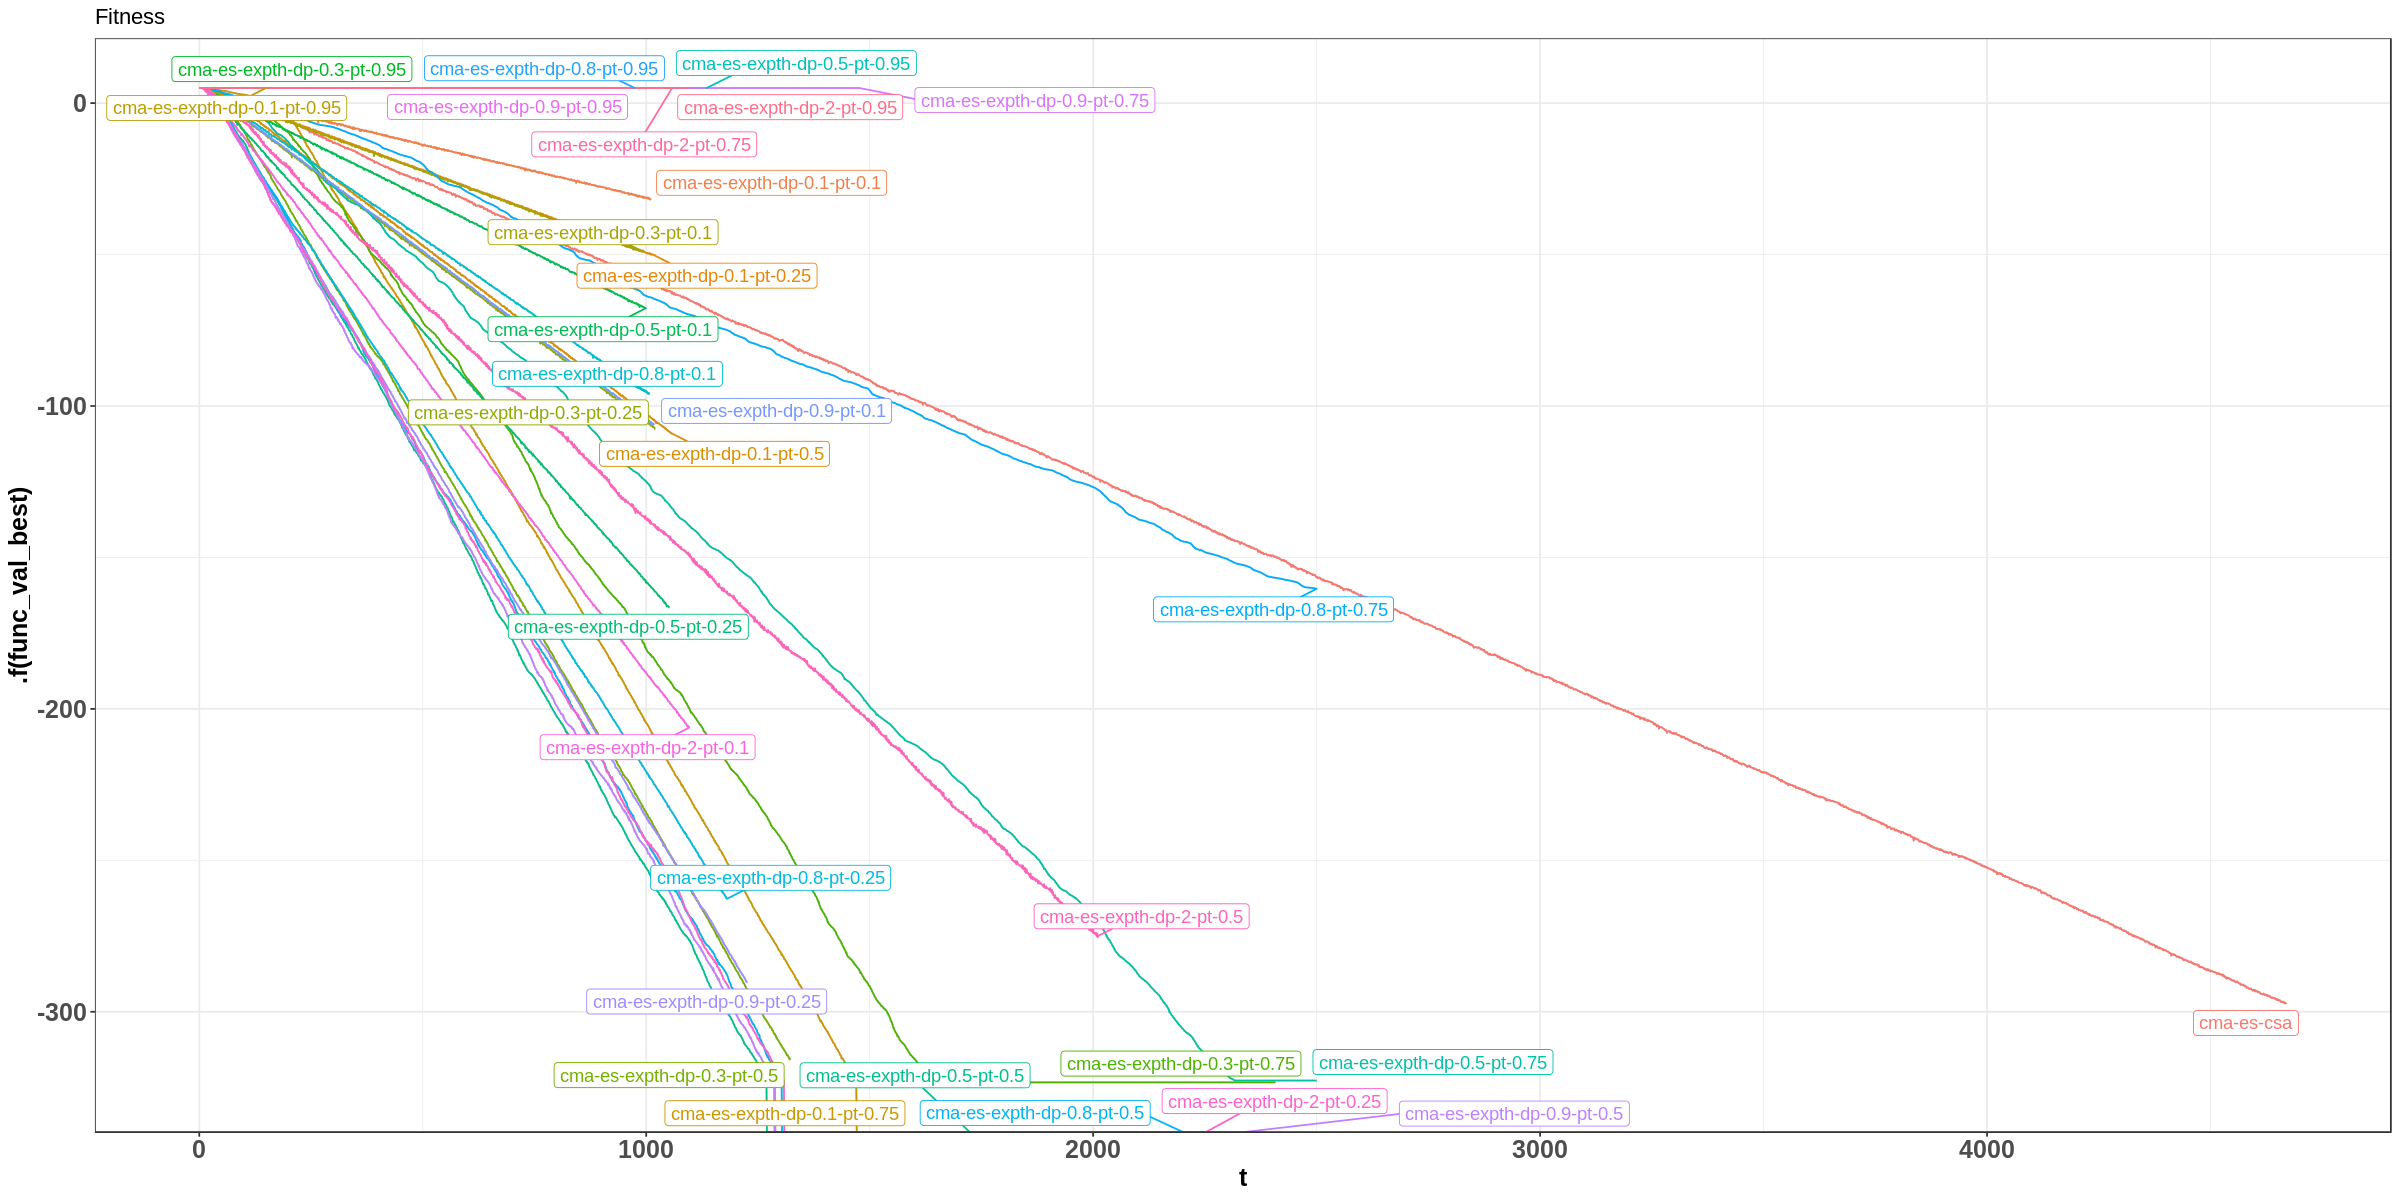

In [30]:
experiments_d10 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(is.character(method), use_direct_label = T)
   

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


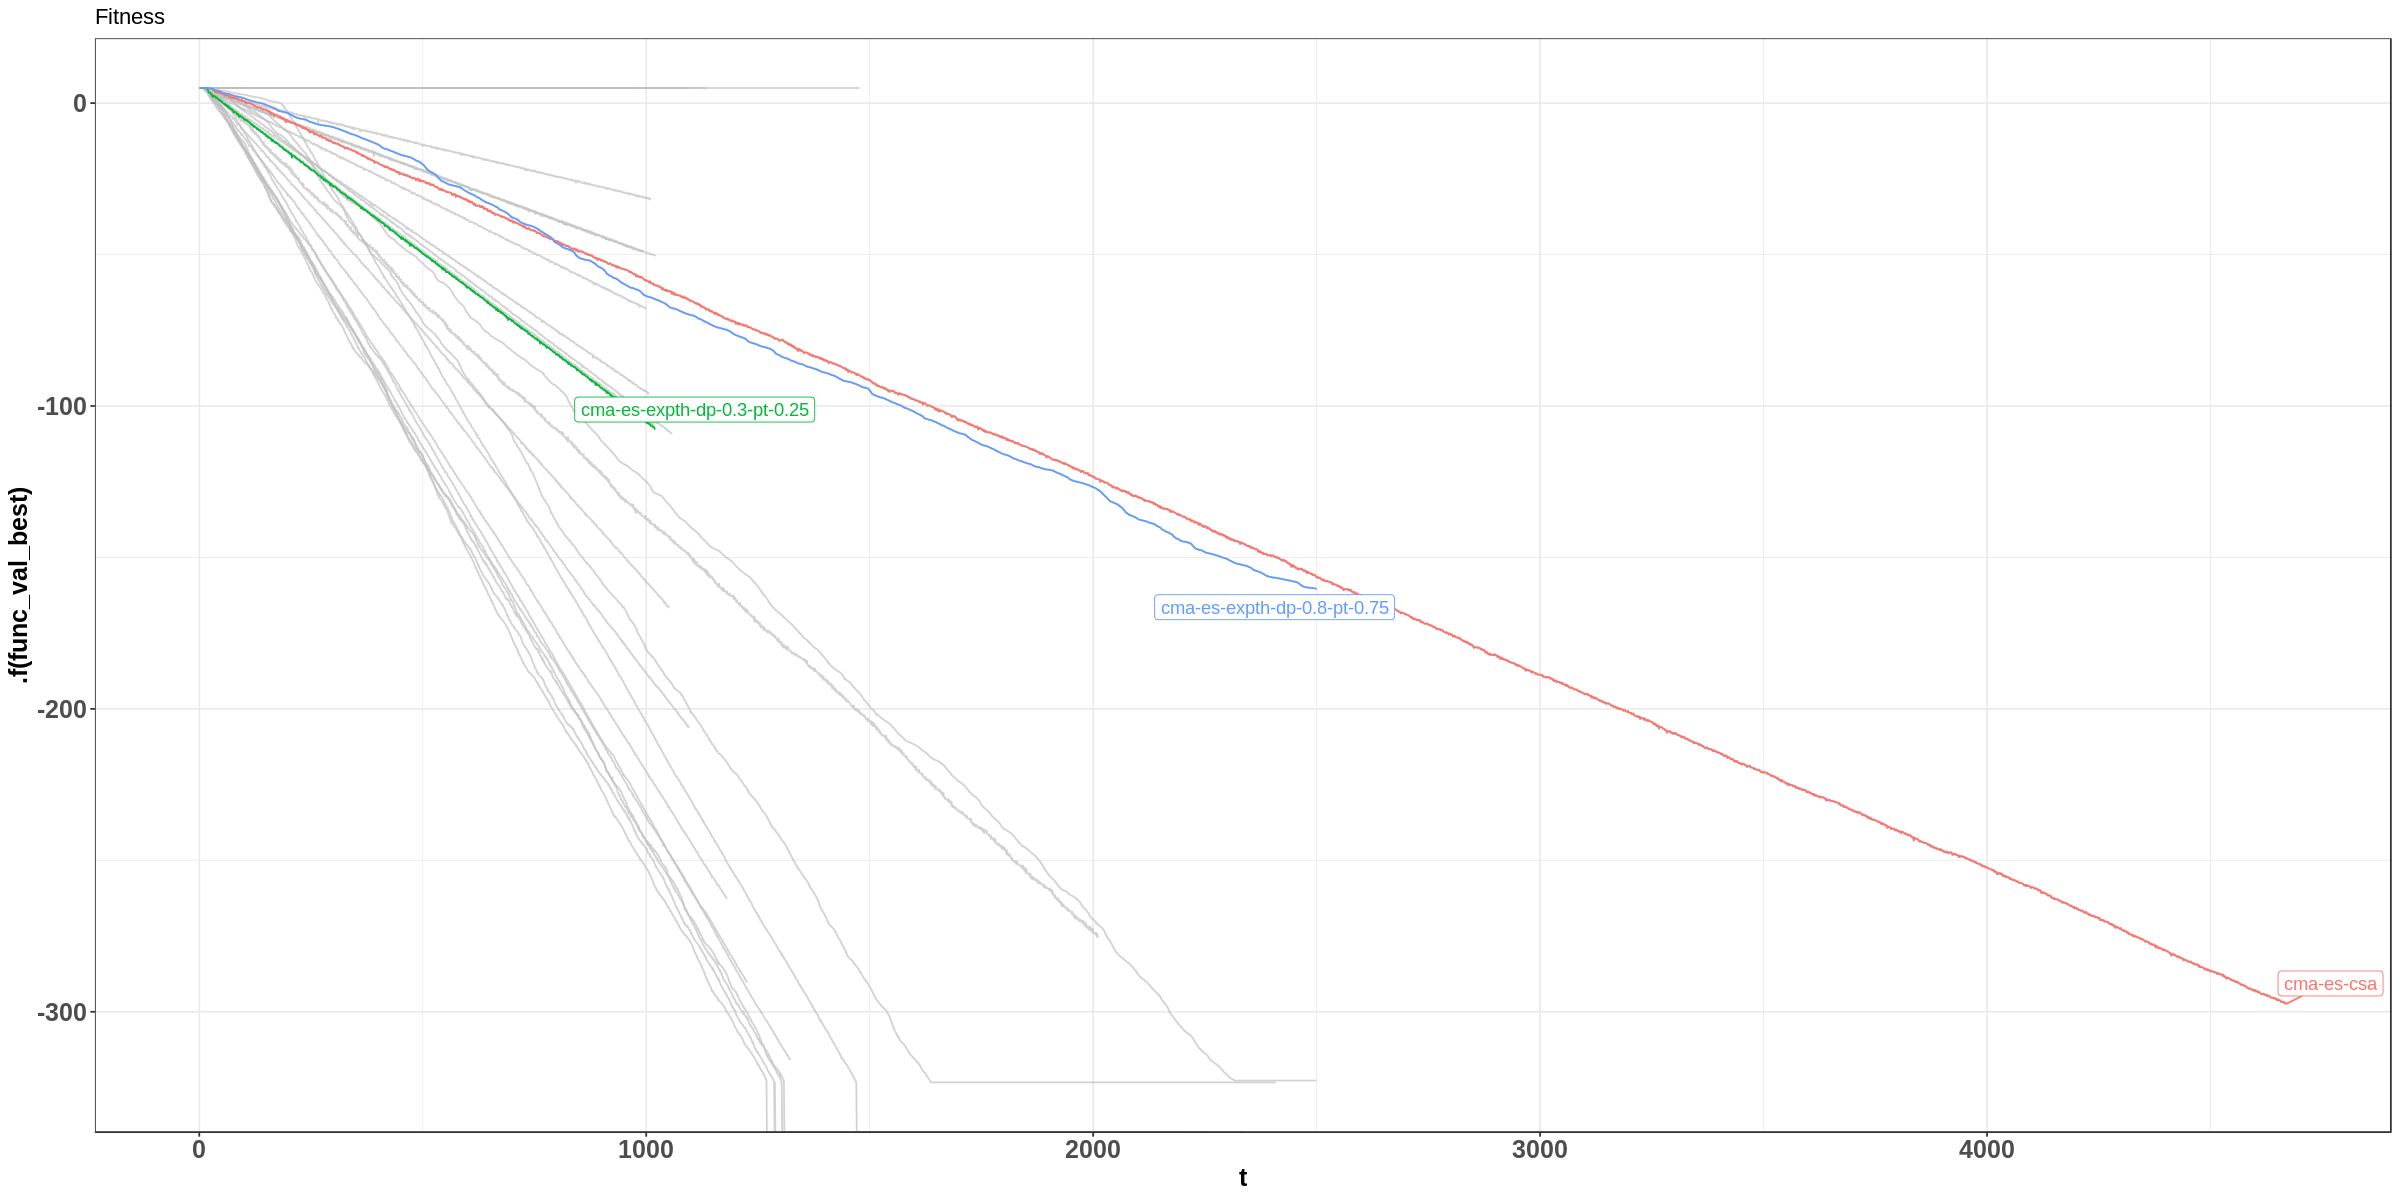

In [33]:
experiments_d10 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-expth-dp-0.3-pt-0.25", "cma-es-csa", "cma-es-expth-dp-0.8-pt-0.75"), use_direct_label = T) 

## D = 30 & Func = sphere

In [34]:
experiments_d30 = 
    do_experiment(
        methods = c(cma_es_csa, expths),
        func = eval_func,
        dim = 30,
        x0 = 100,
        lower = -100,
        upper = 100
    )

Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preser

label_key: method


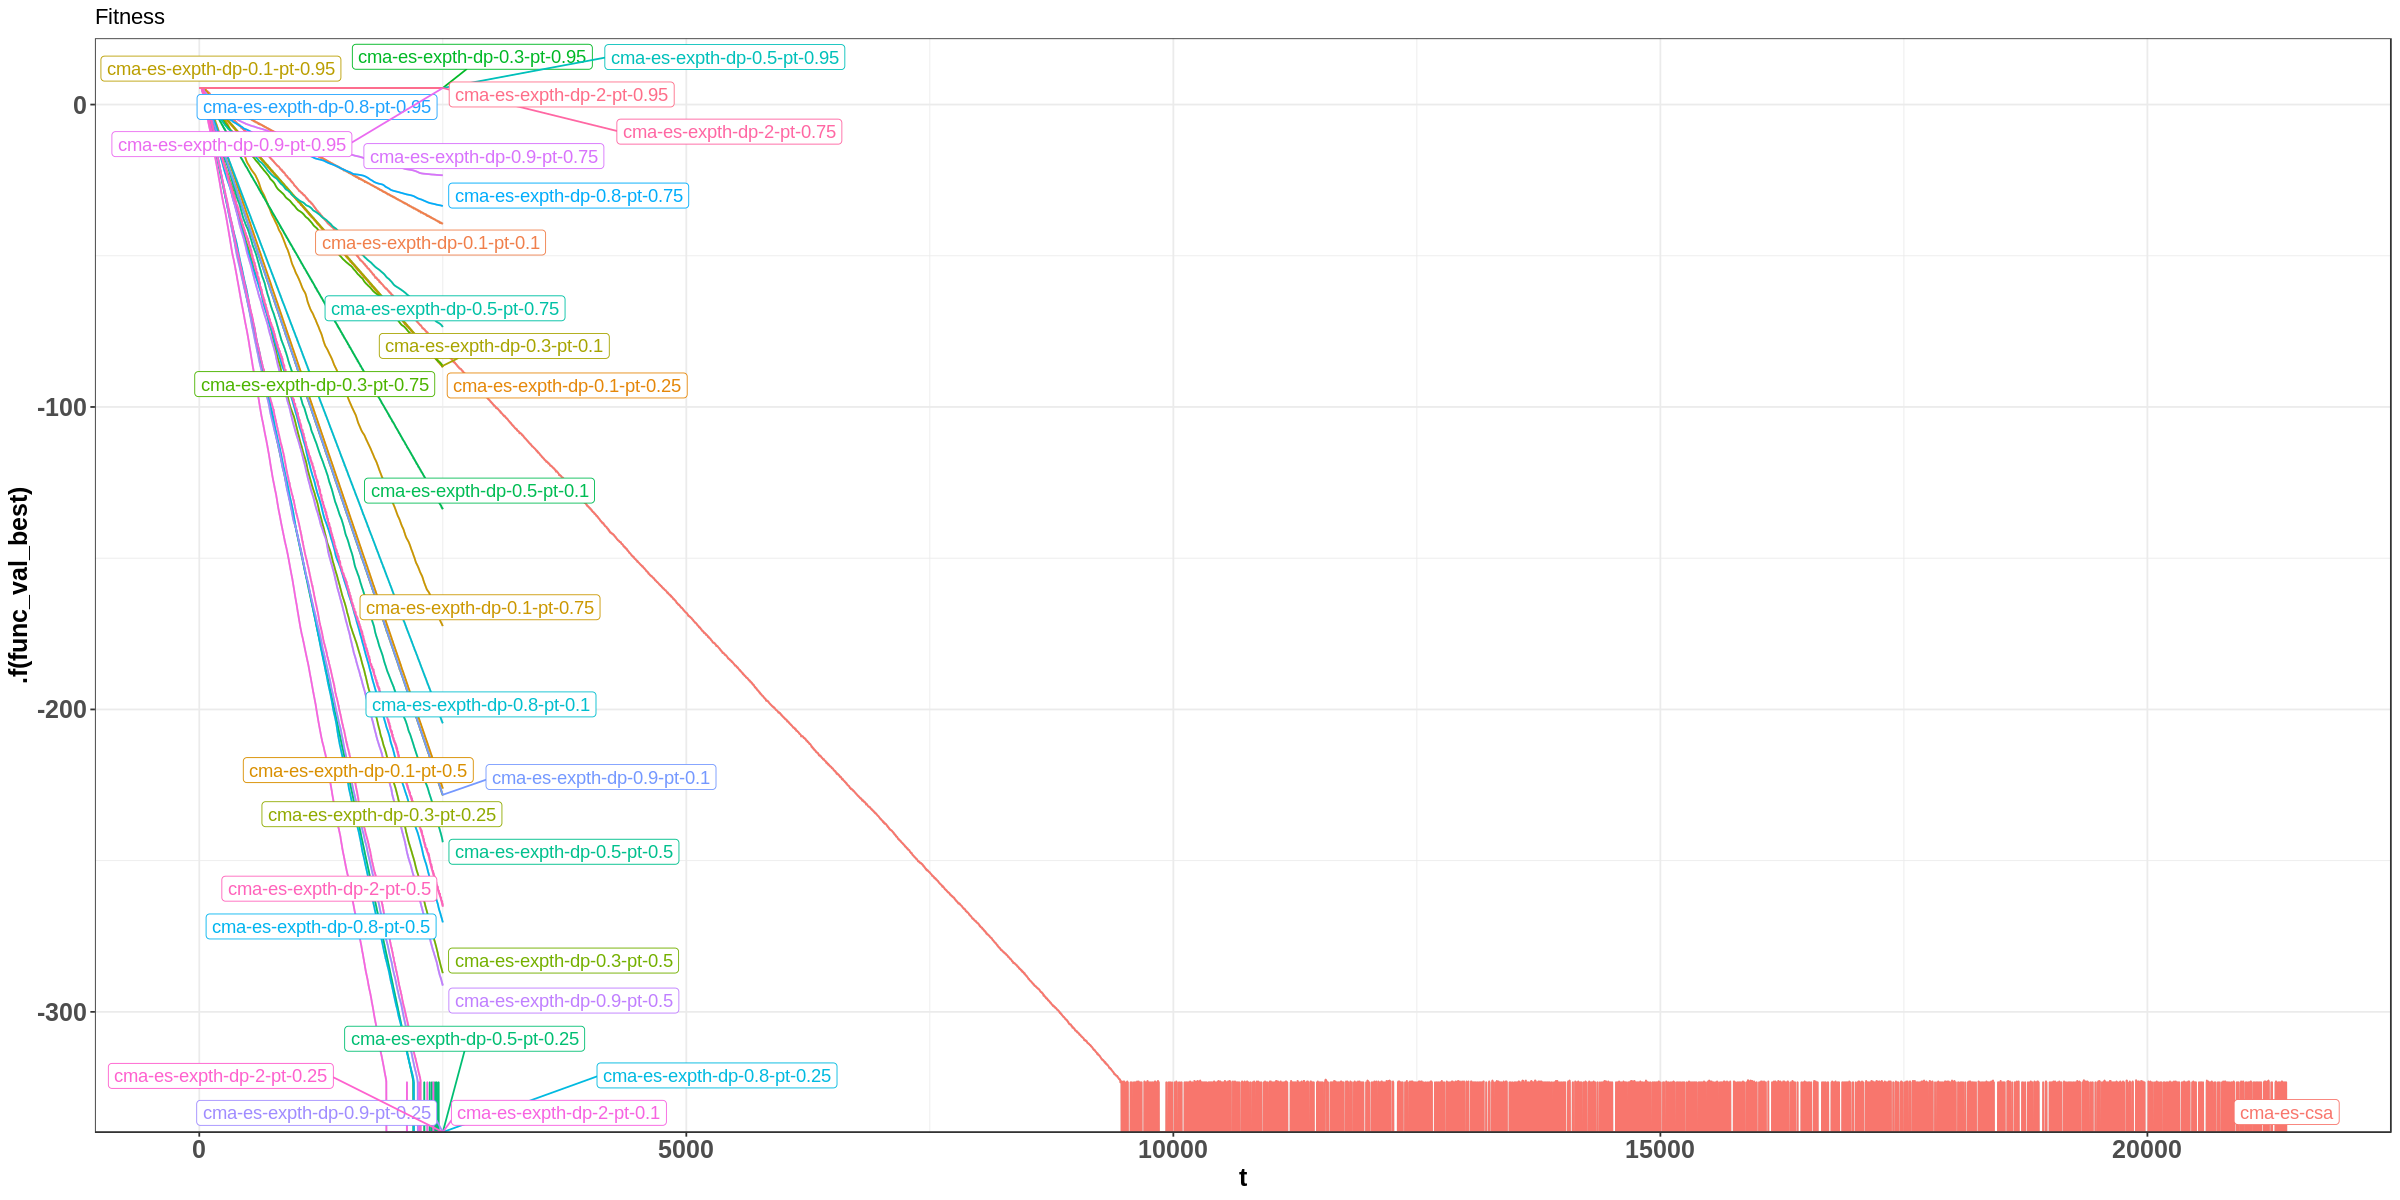

In [35]:
experiments_d30 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(is.character(method), use_direct_label = T)
    

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


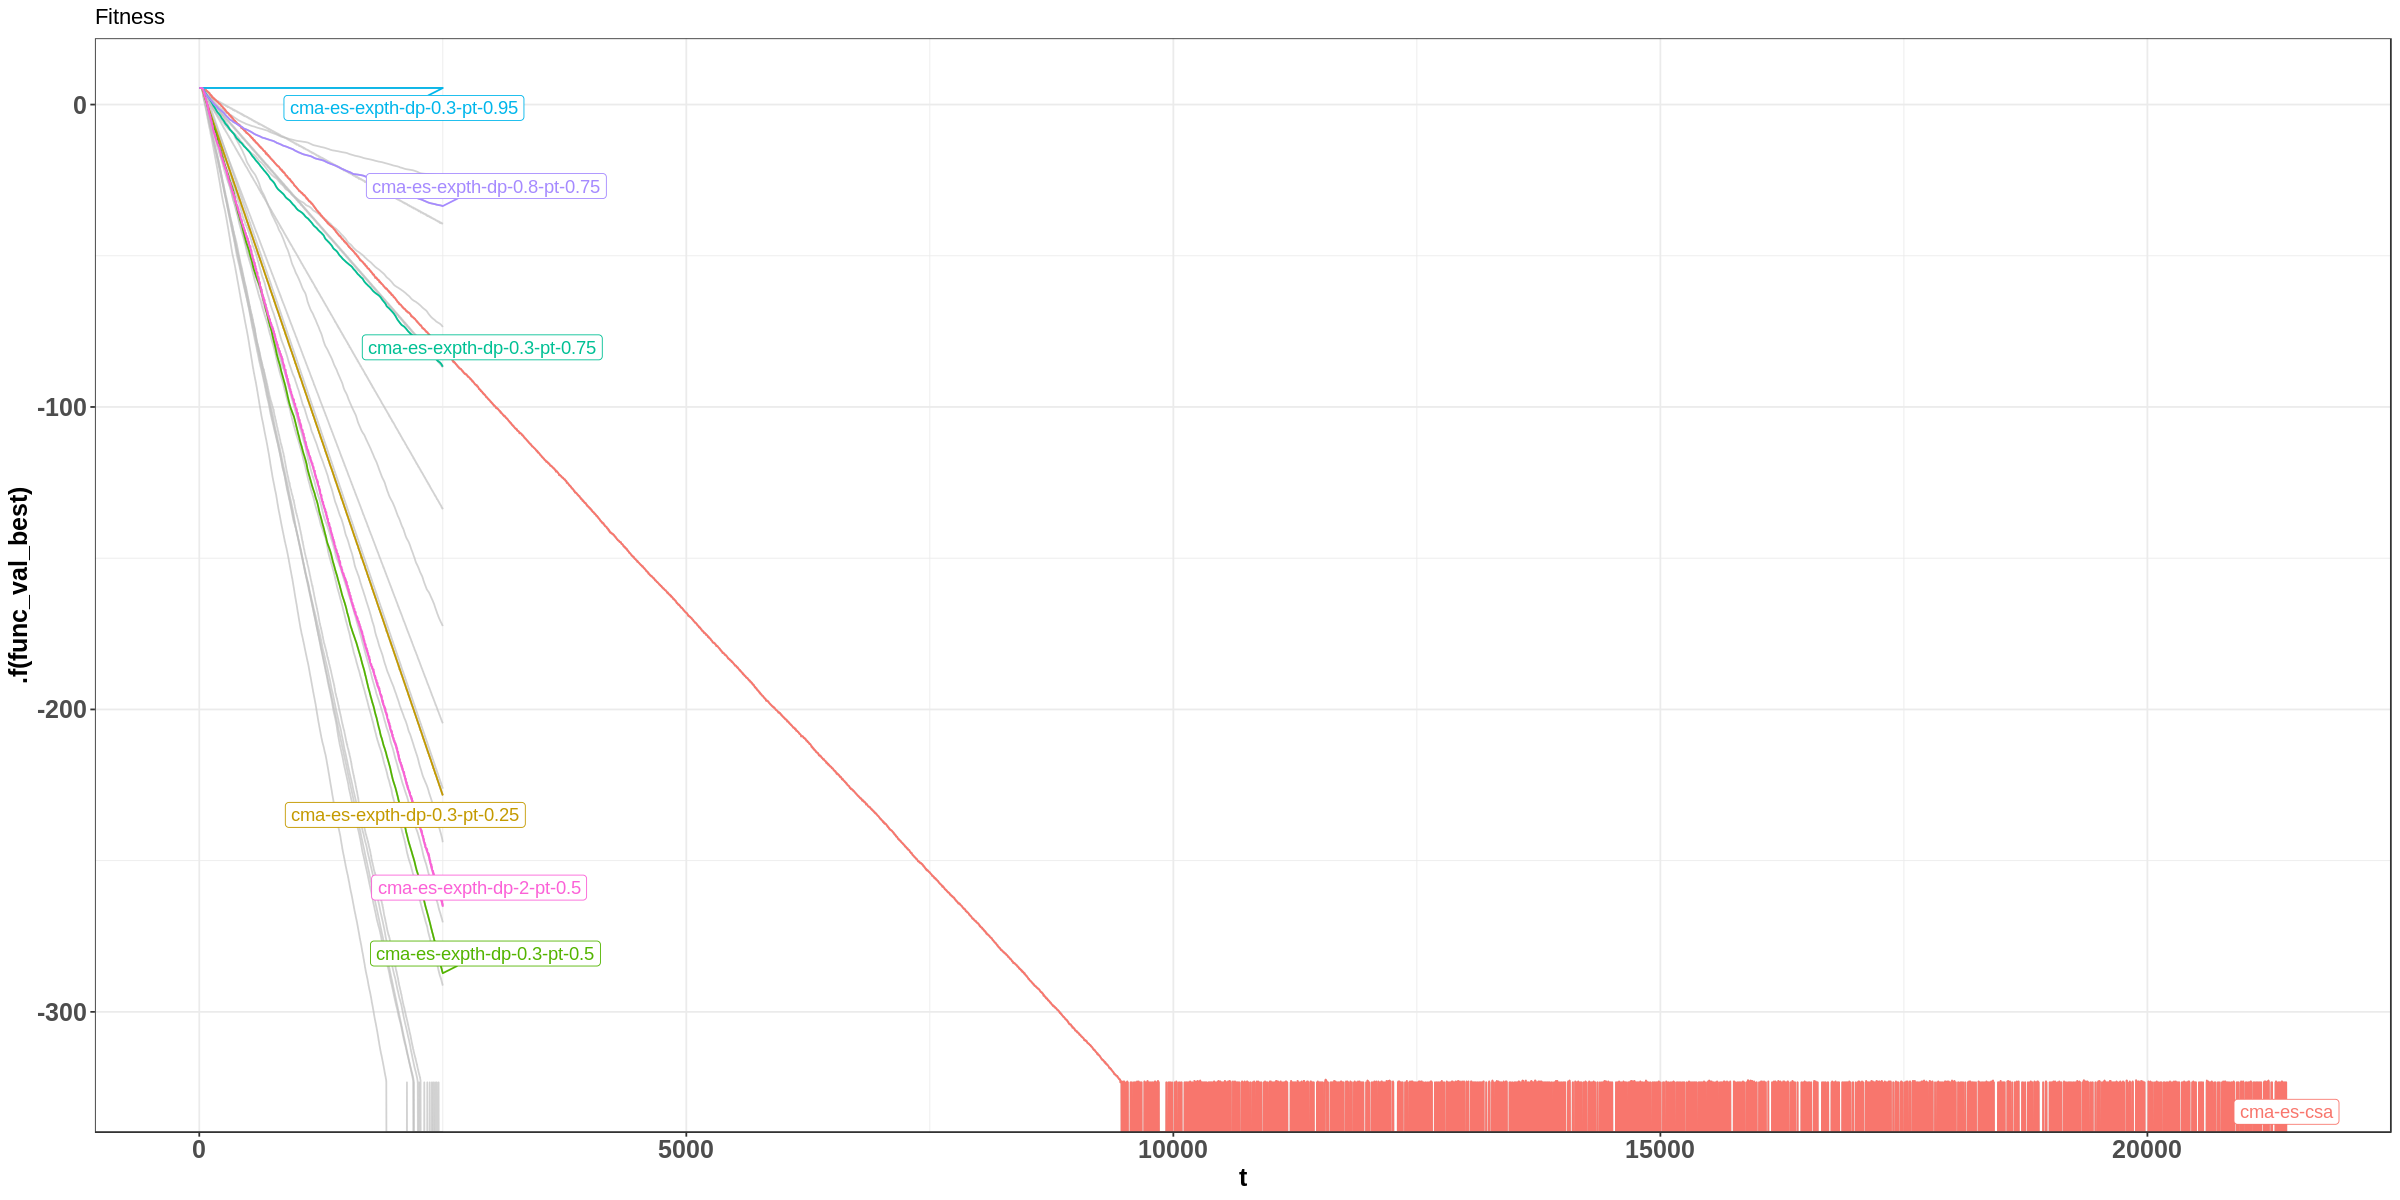

In [99]:
experiments_d30 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-expth-dp-0.3-pt-0.25", "cma-es-csa", "cma-es-expth-dp-0.3-pt-0.95", "cma-es-expth-dp-0.3-pt-0.75", "cma-es-expth-dp-0.3-pt-0.5", "cma-es-expth-dp-2-pt-0.5", "cma-es-expth-dp-0.8-pt-0.75"), use_direct_label = T) 

## D = 10 & Func = Rastrigin

In [69]:
experiments_d10_rastr = 
    do_experiment(
        methods = c(cma_es_csa, expths),
        func = rastrigin_func,
        dim = 10,
        x0 = 100,
        lower = -100,
        upper = 100
    )

Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preser

label_key: method


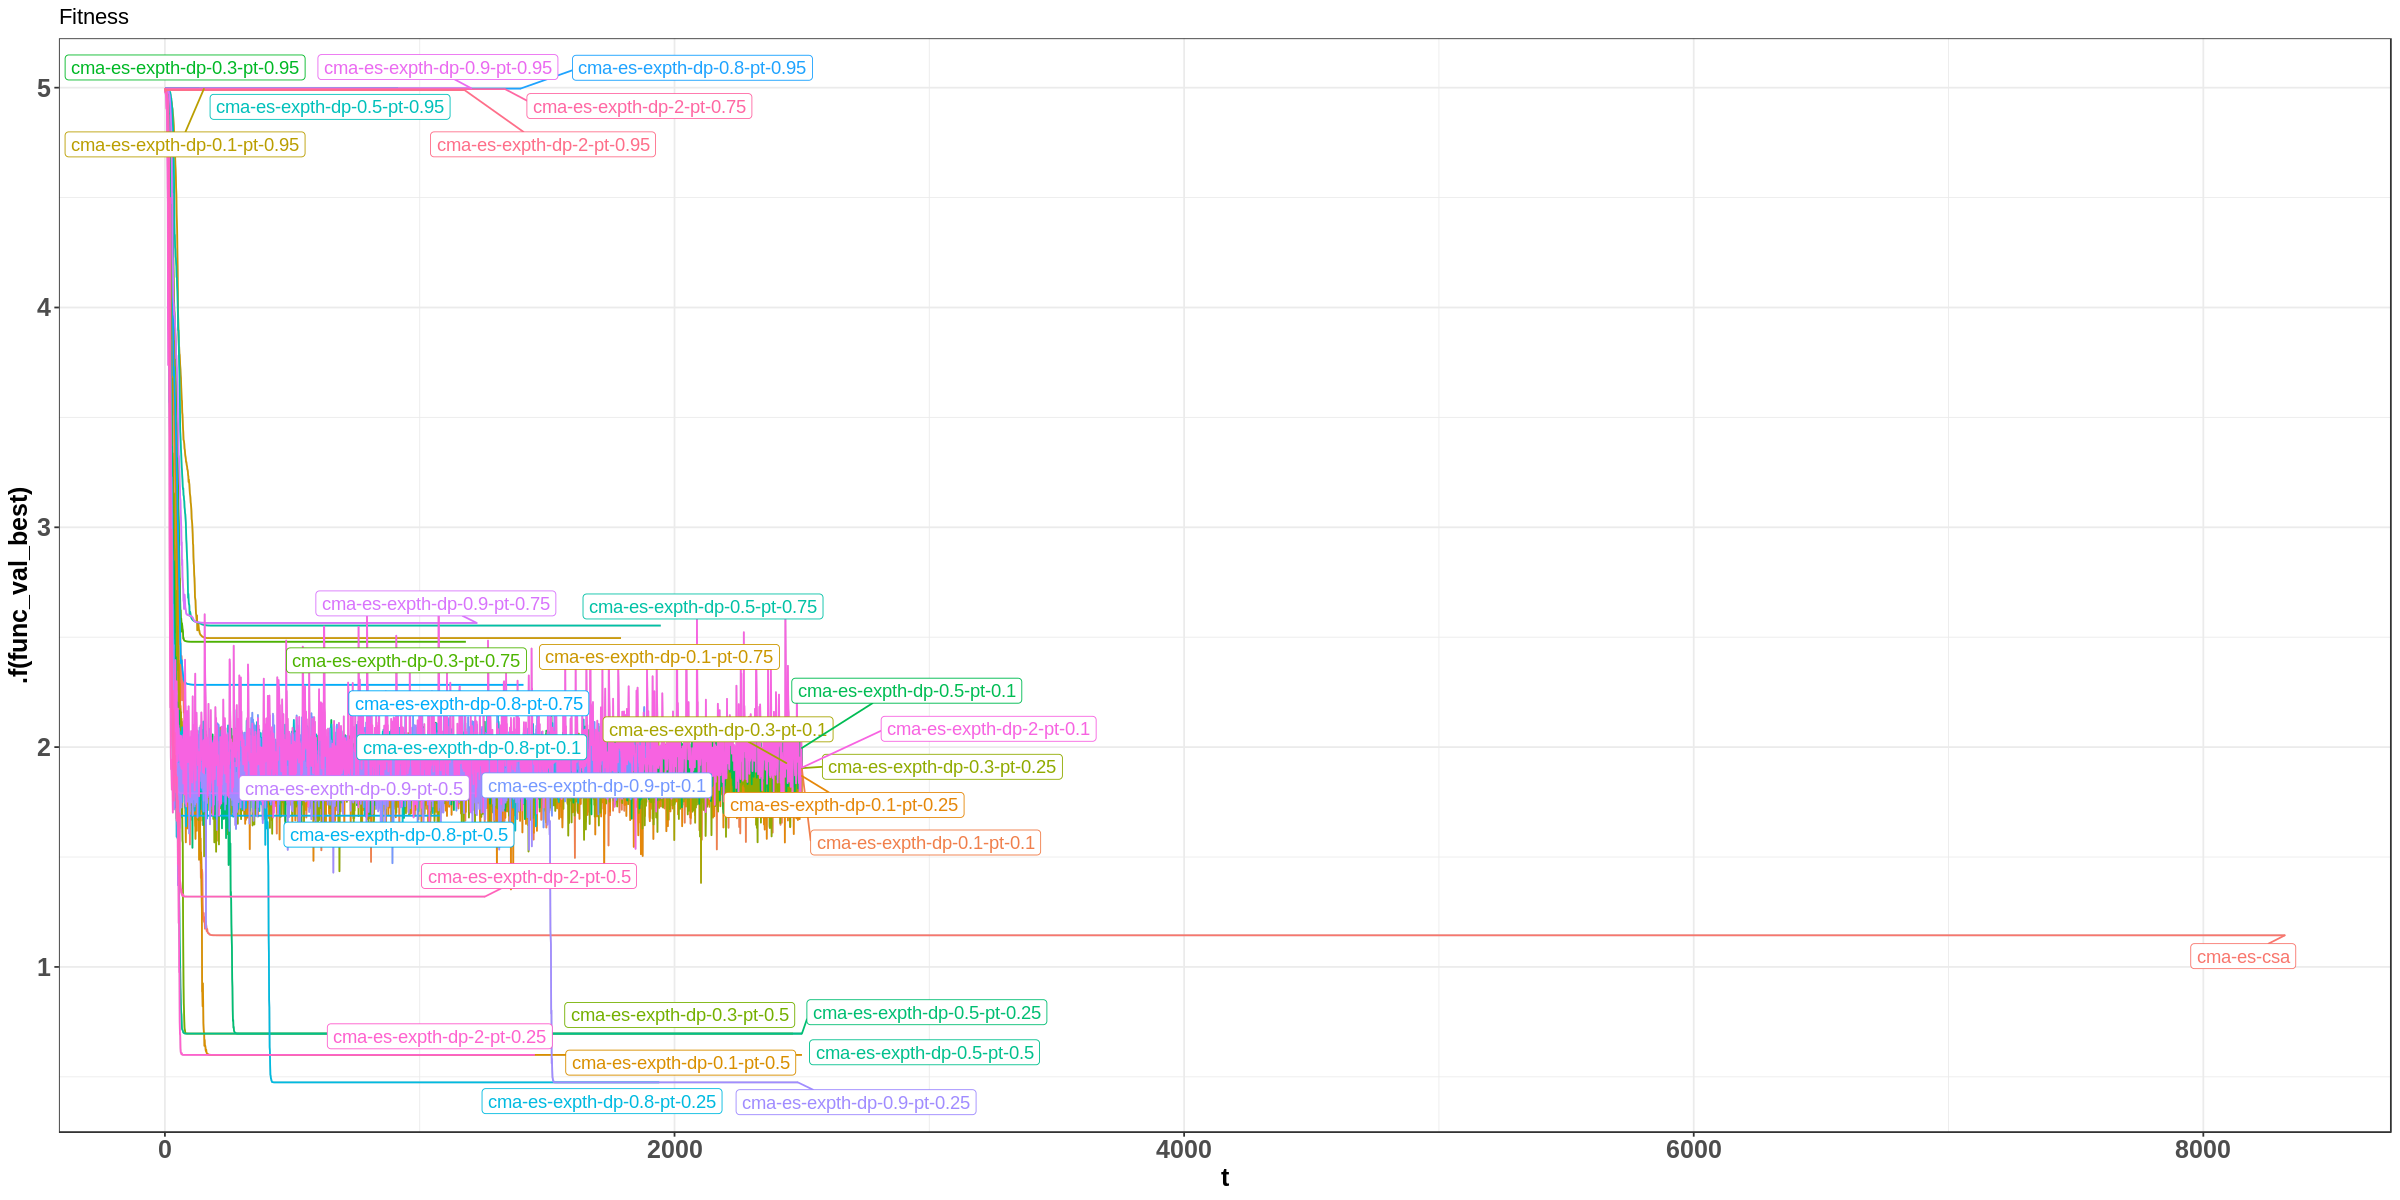

In [48]:
experiments_d10_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(is.character(method), use_direct_label = T)
   

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


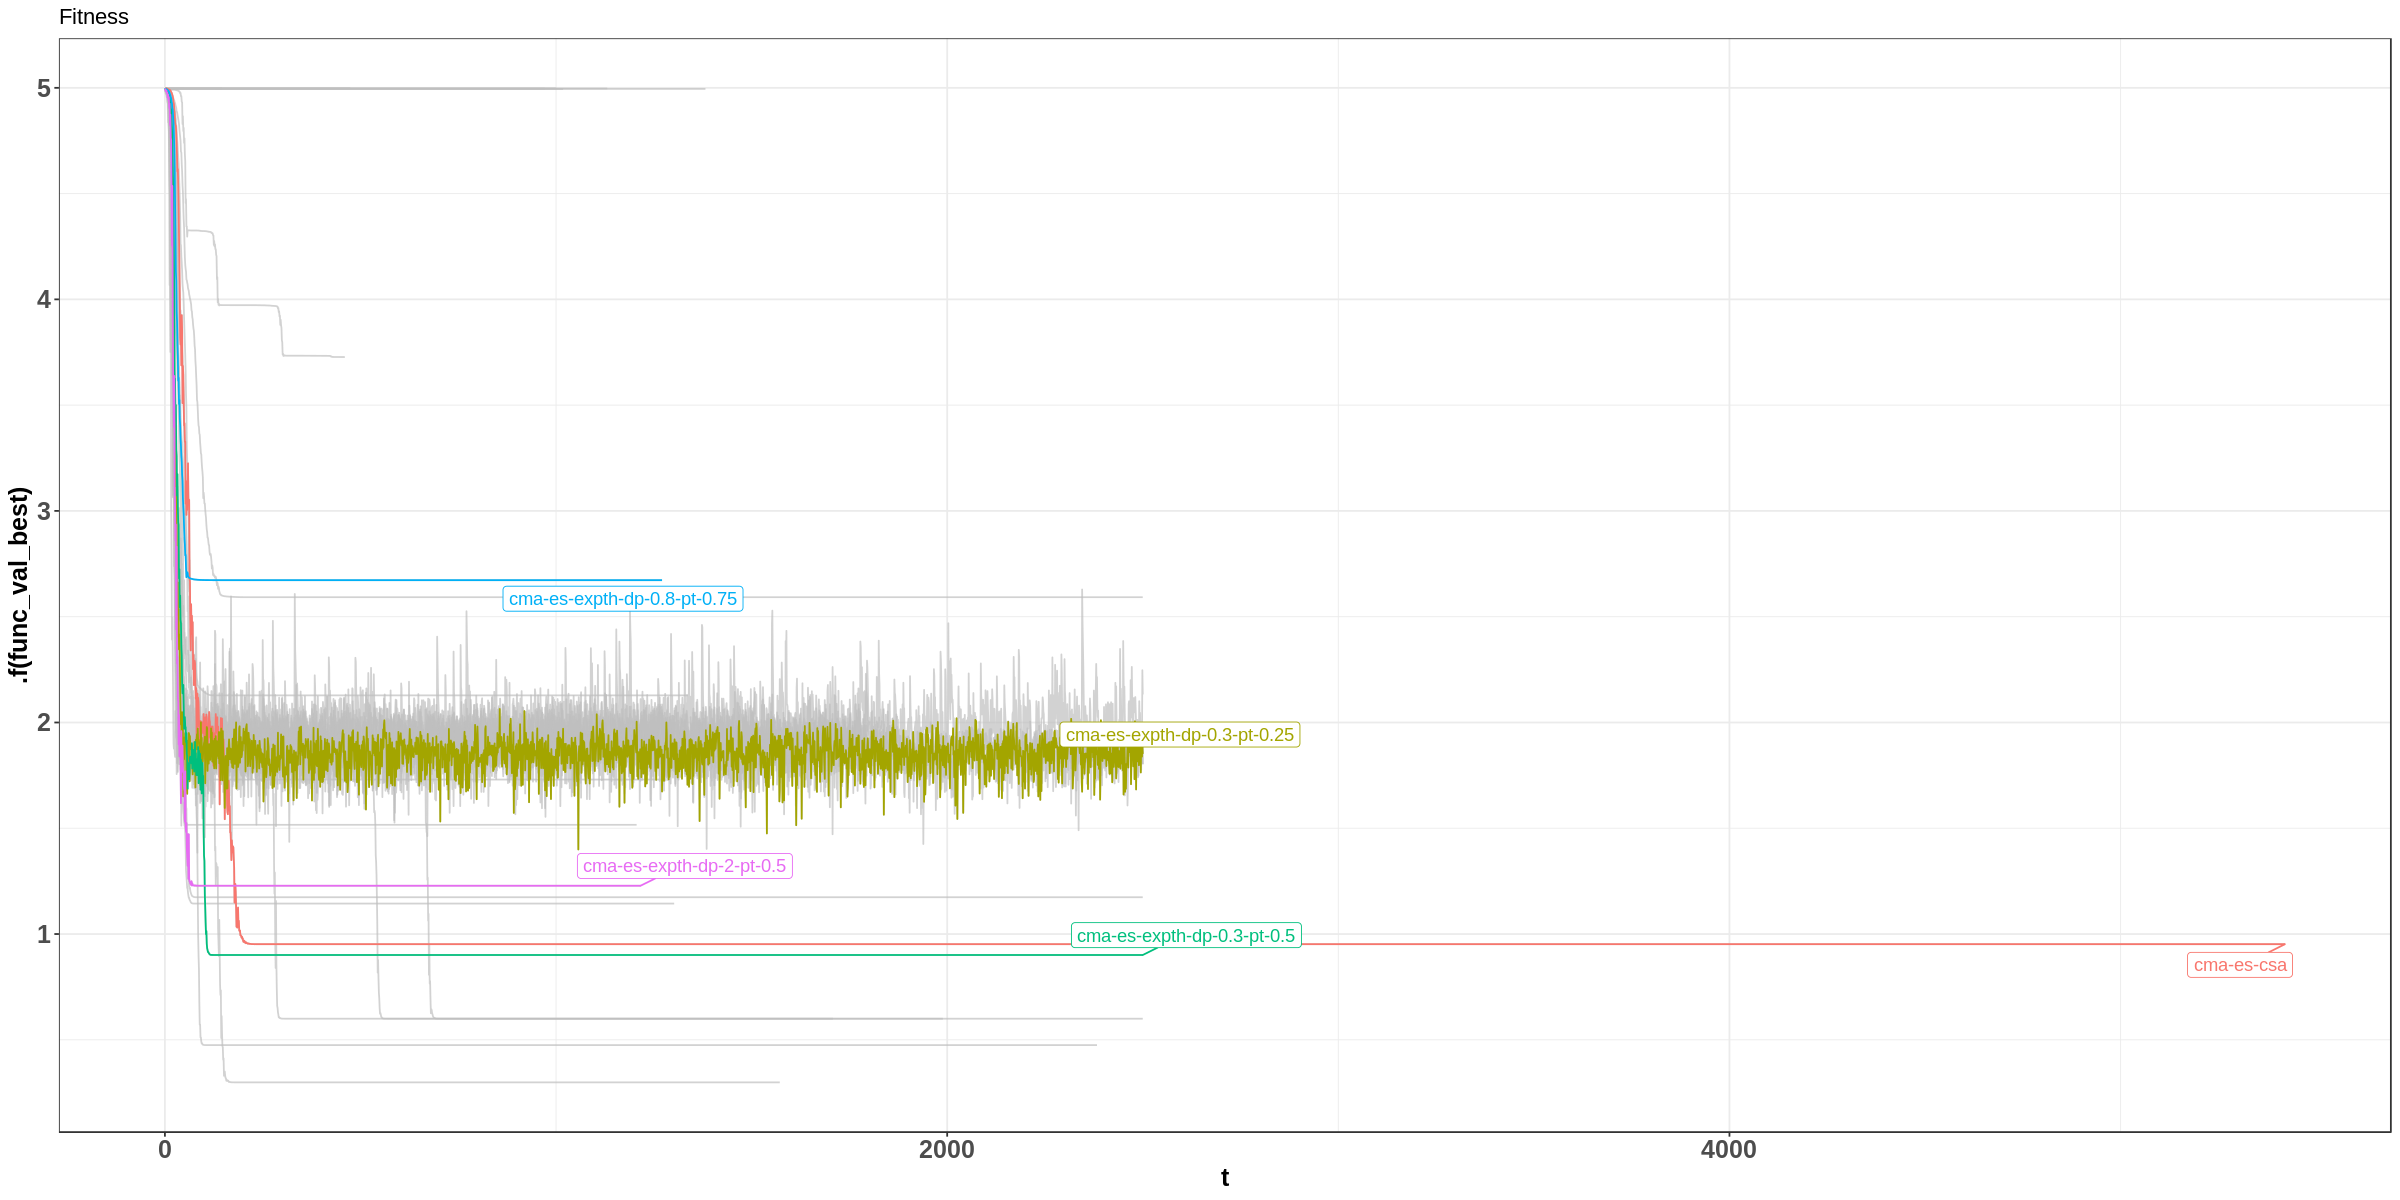

In [94]:
experiments_d10_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-expth-dp-0.3-pt-0.25", "cma-es-csa", "cma-es-expth-dp-0.3-pt-0.5", "cma-es-expth-dp-2-pt-0.5", "cma-es-expth-dp-0.8-pt-0.75"), use_direct_label = T) 

## D = 30 & Func = Rastrigin

In [89]:
experiments_d30_rastr = 
    do_experiment(
        methods = c(cma_es_csa, expths),
        func = rastrigin_func,
        dim = 30,
        x0 = 100,
        lower = -100,
        upper = 100
    )

Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preser

label_key: method


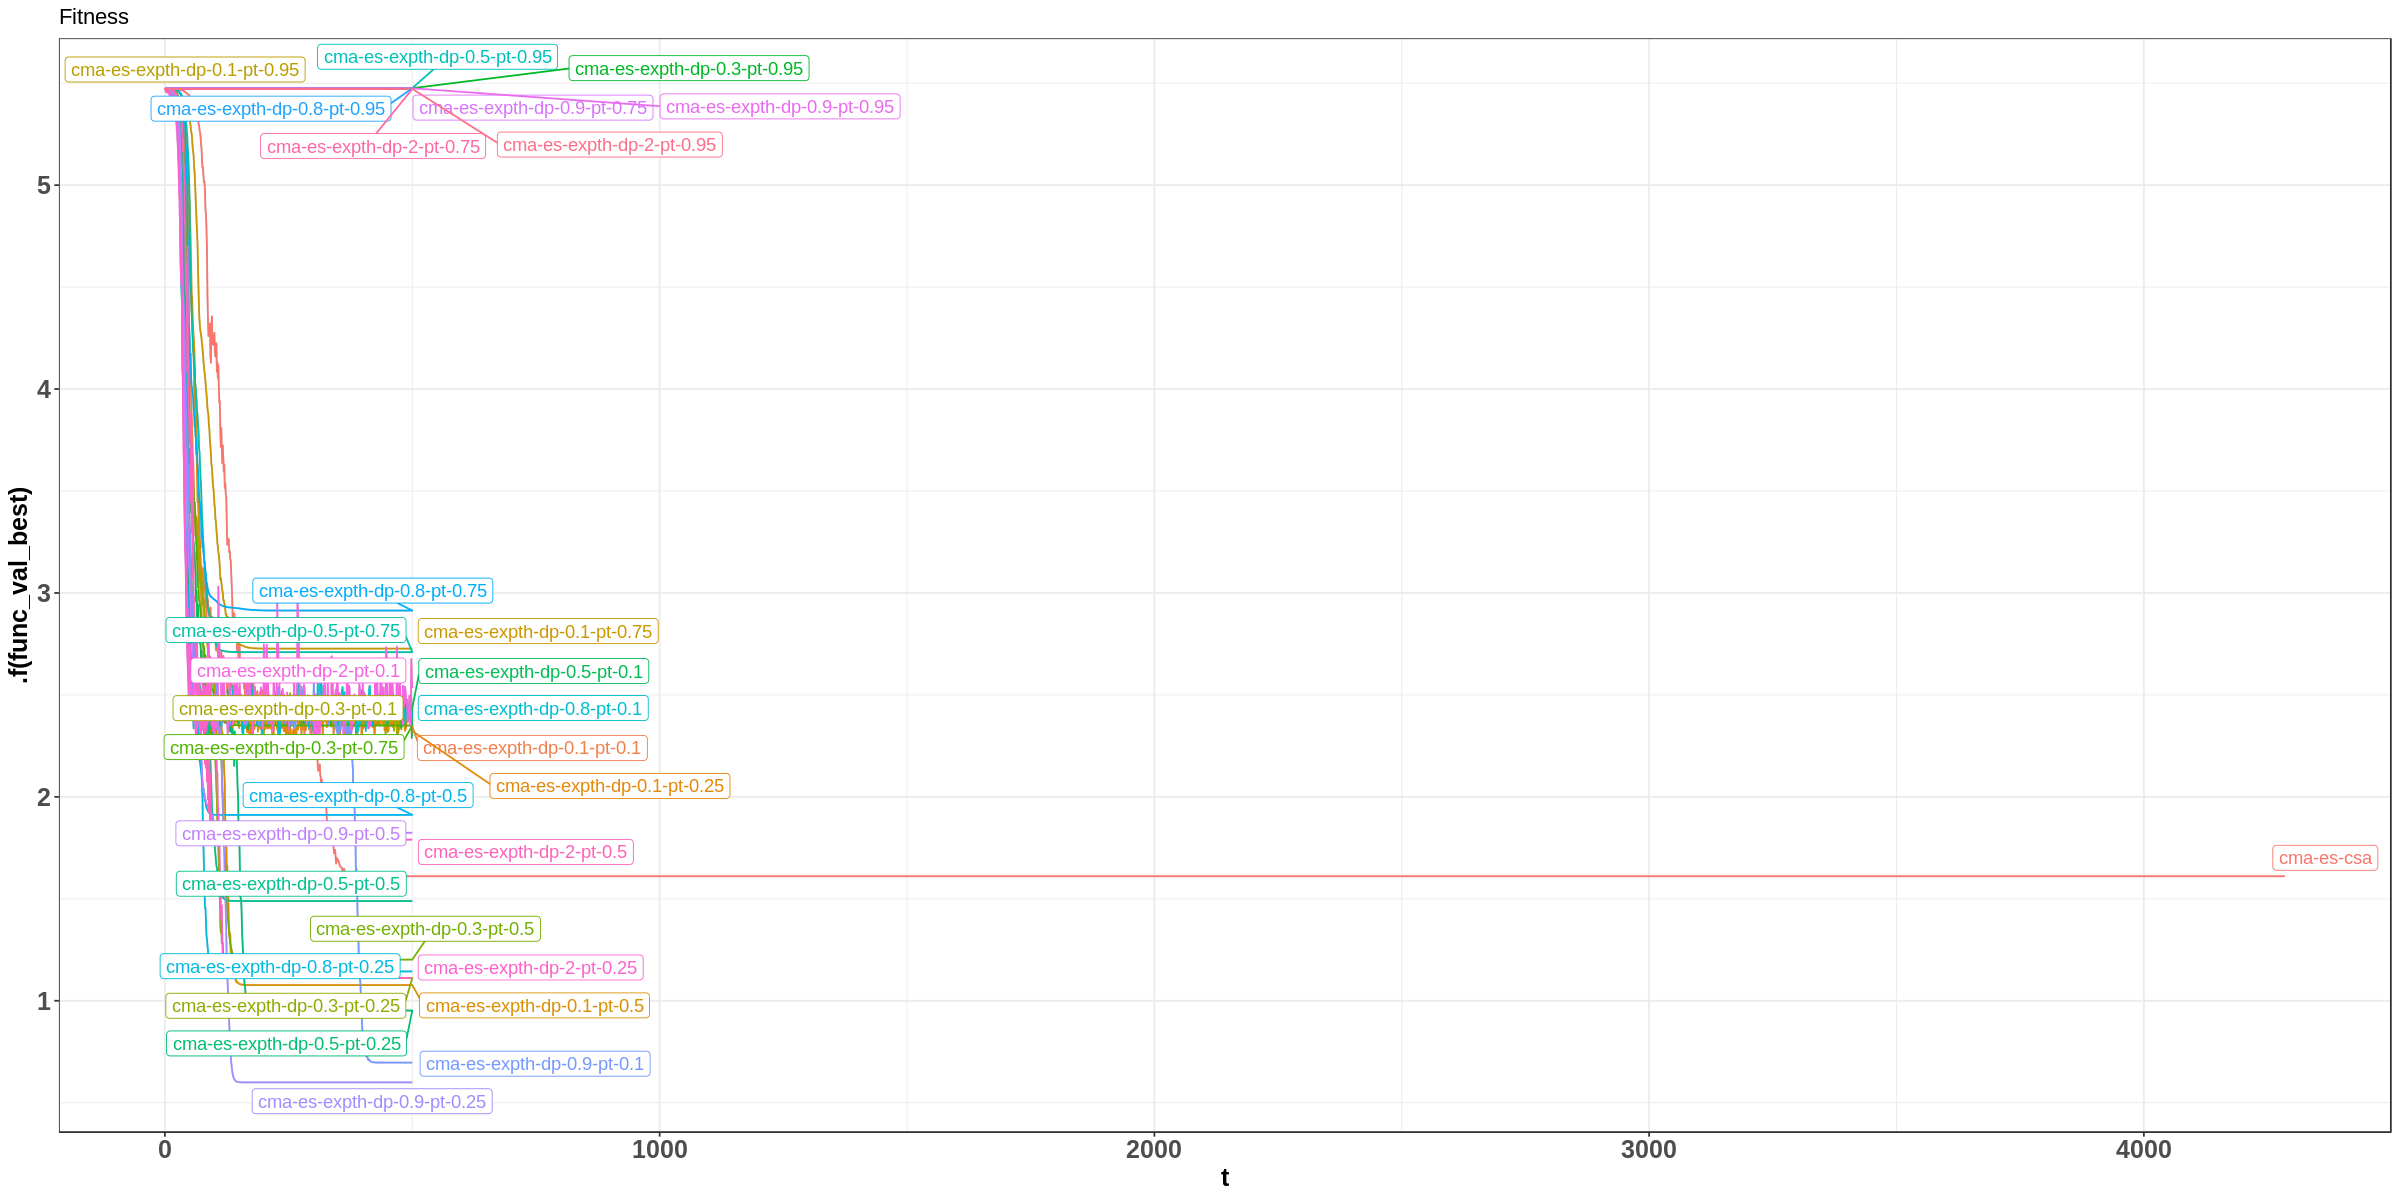

In [90]:
experiments_d30_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(is.character(method), use_direct_label = T)
    

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


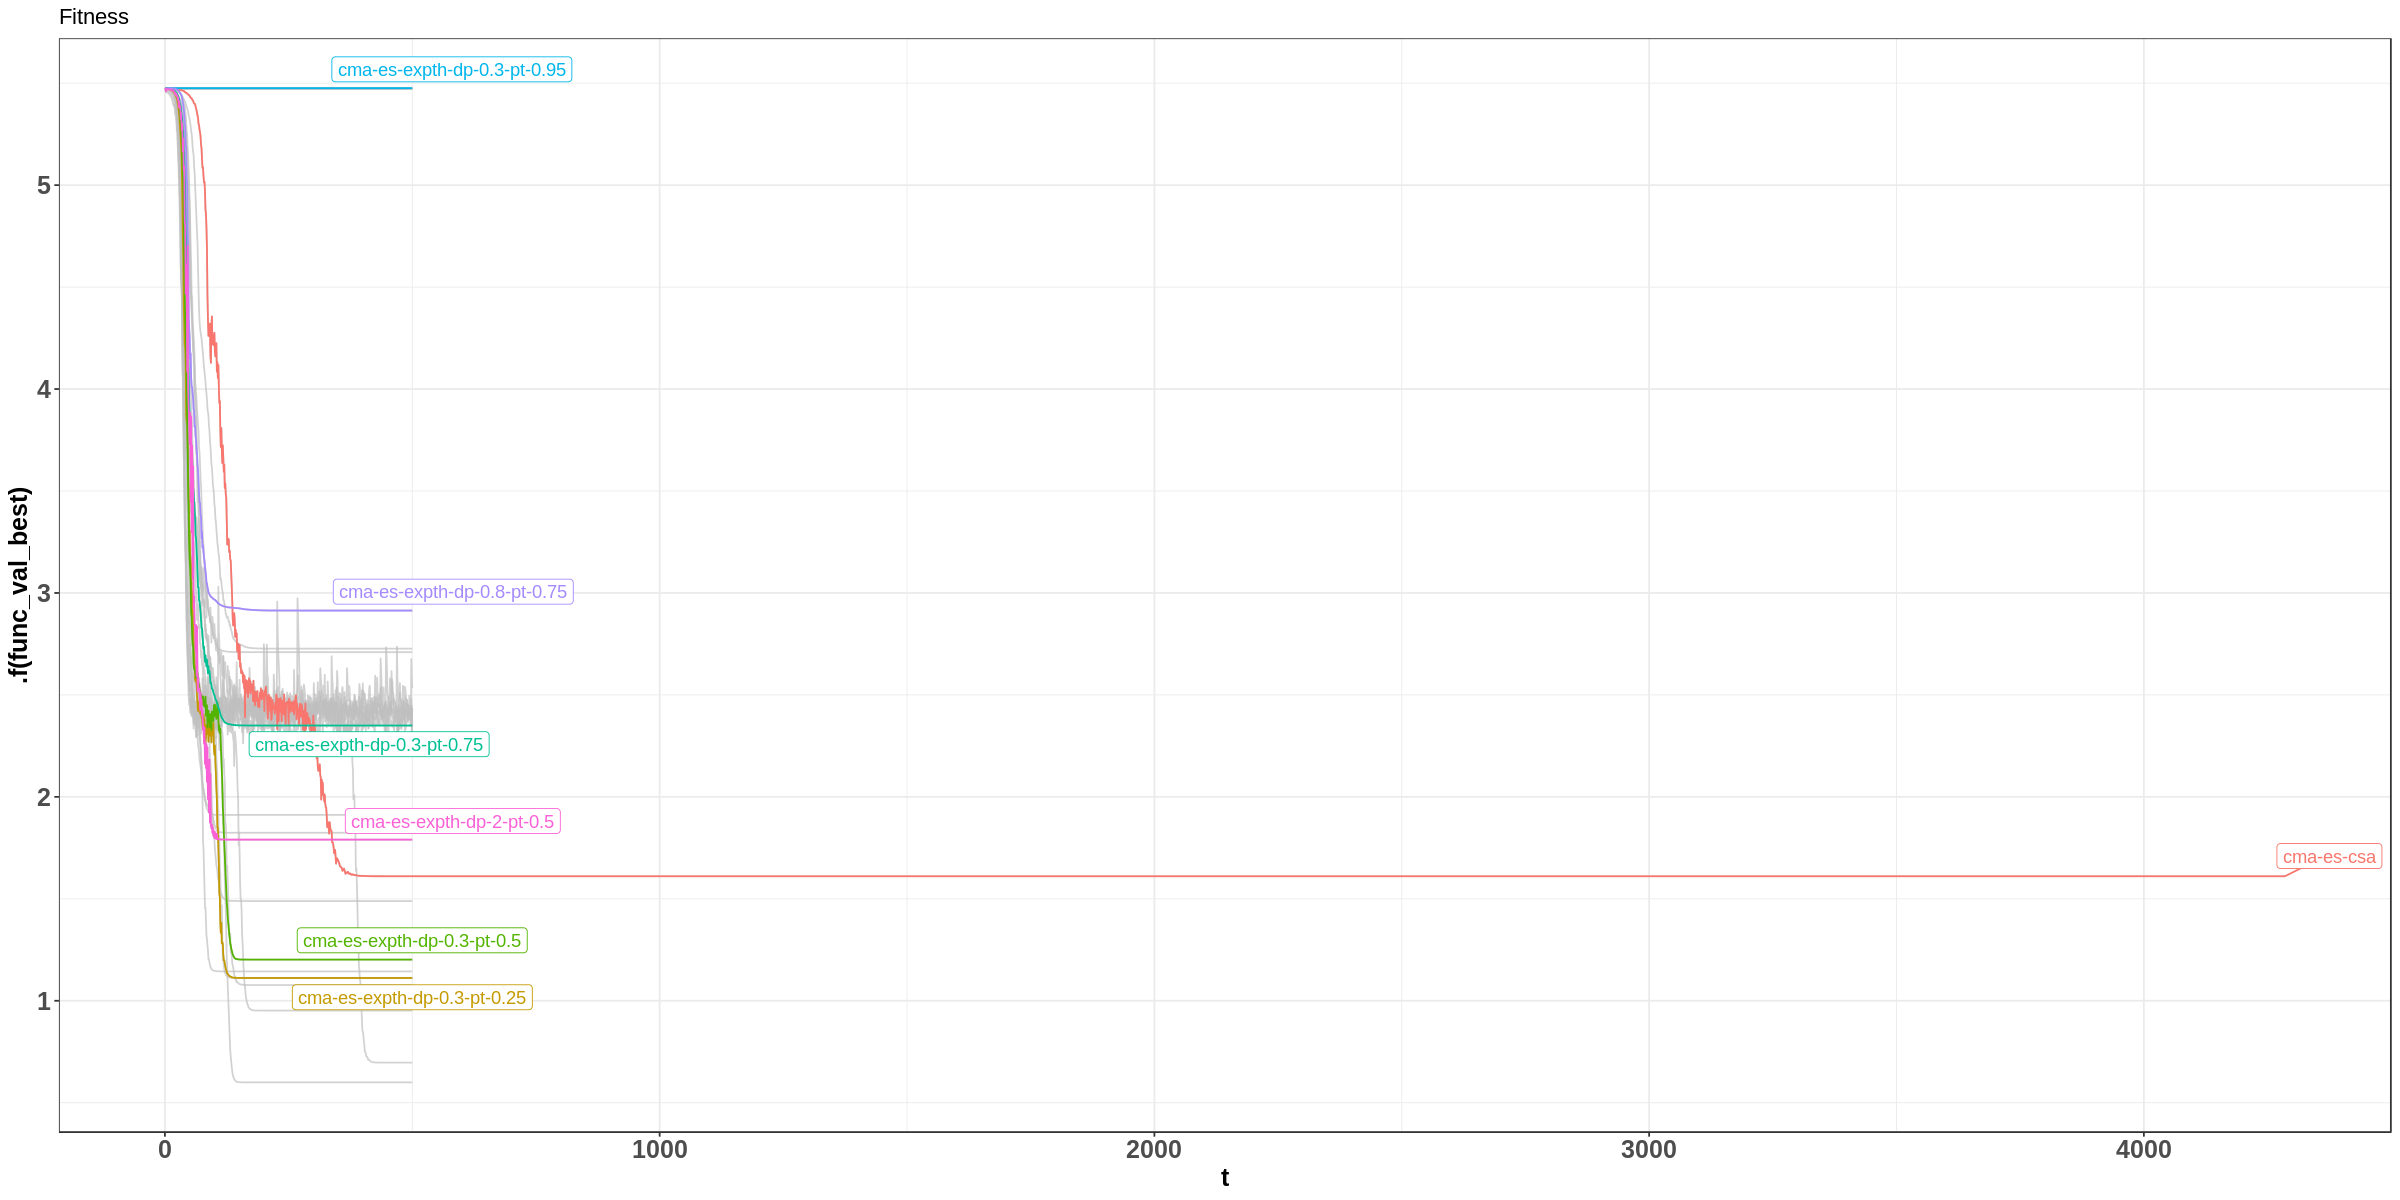

In [98]:
experiments_d30_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-expth-dp-0.3-pt-0.25", "cma-es-csa", "cma-es-expth-dp-0.3-pt-0.95", "cma-es-expth-dp-0.3-pt-0.75", "cma-es-expth-dp-0.3-pt-0.5", "cma-es-expth-dp-2-pt-0.5", "cma-es-expth-dp-0.8-pt-0.75"), use_direct_label = T) 

## const P_target = 0.75 & Func = sphere & Rastrigin
### D_param in (0.1, 0.3, 0.5, 0.8, 0.9, 2)

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


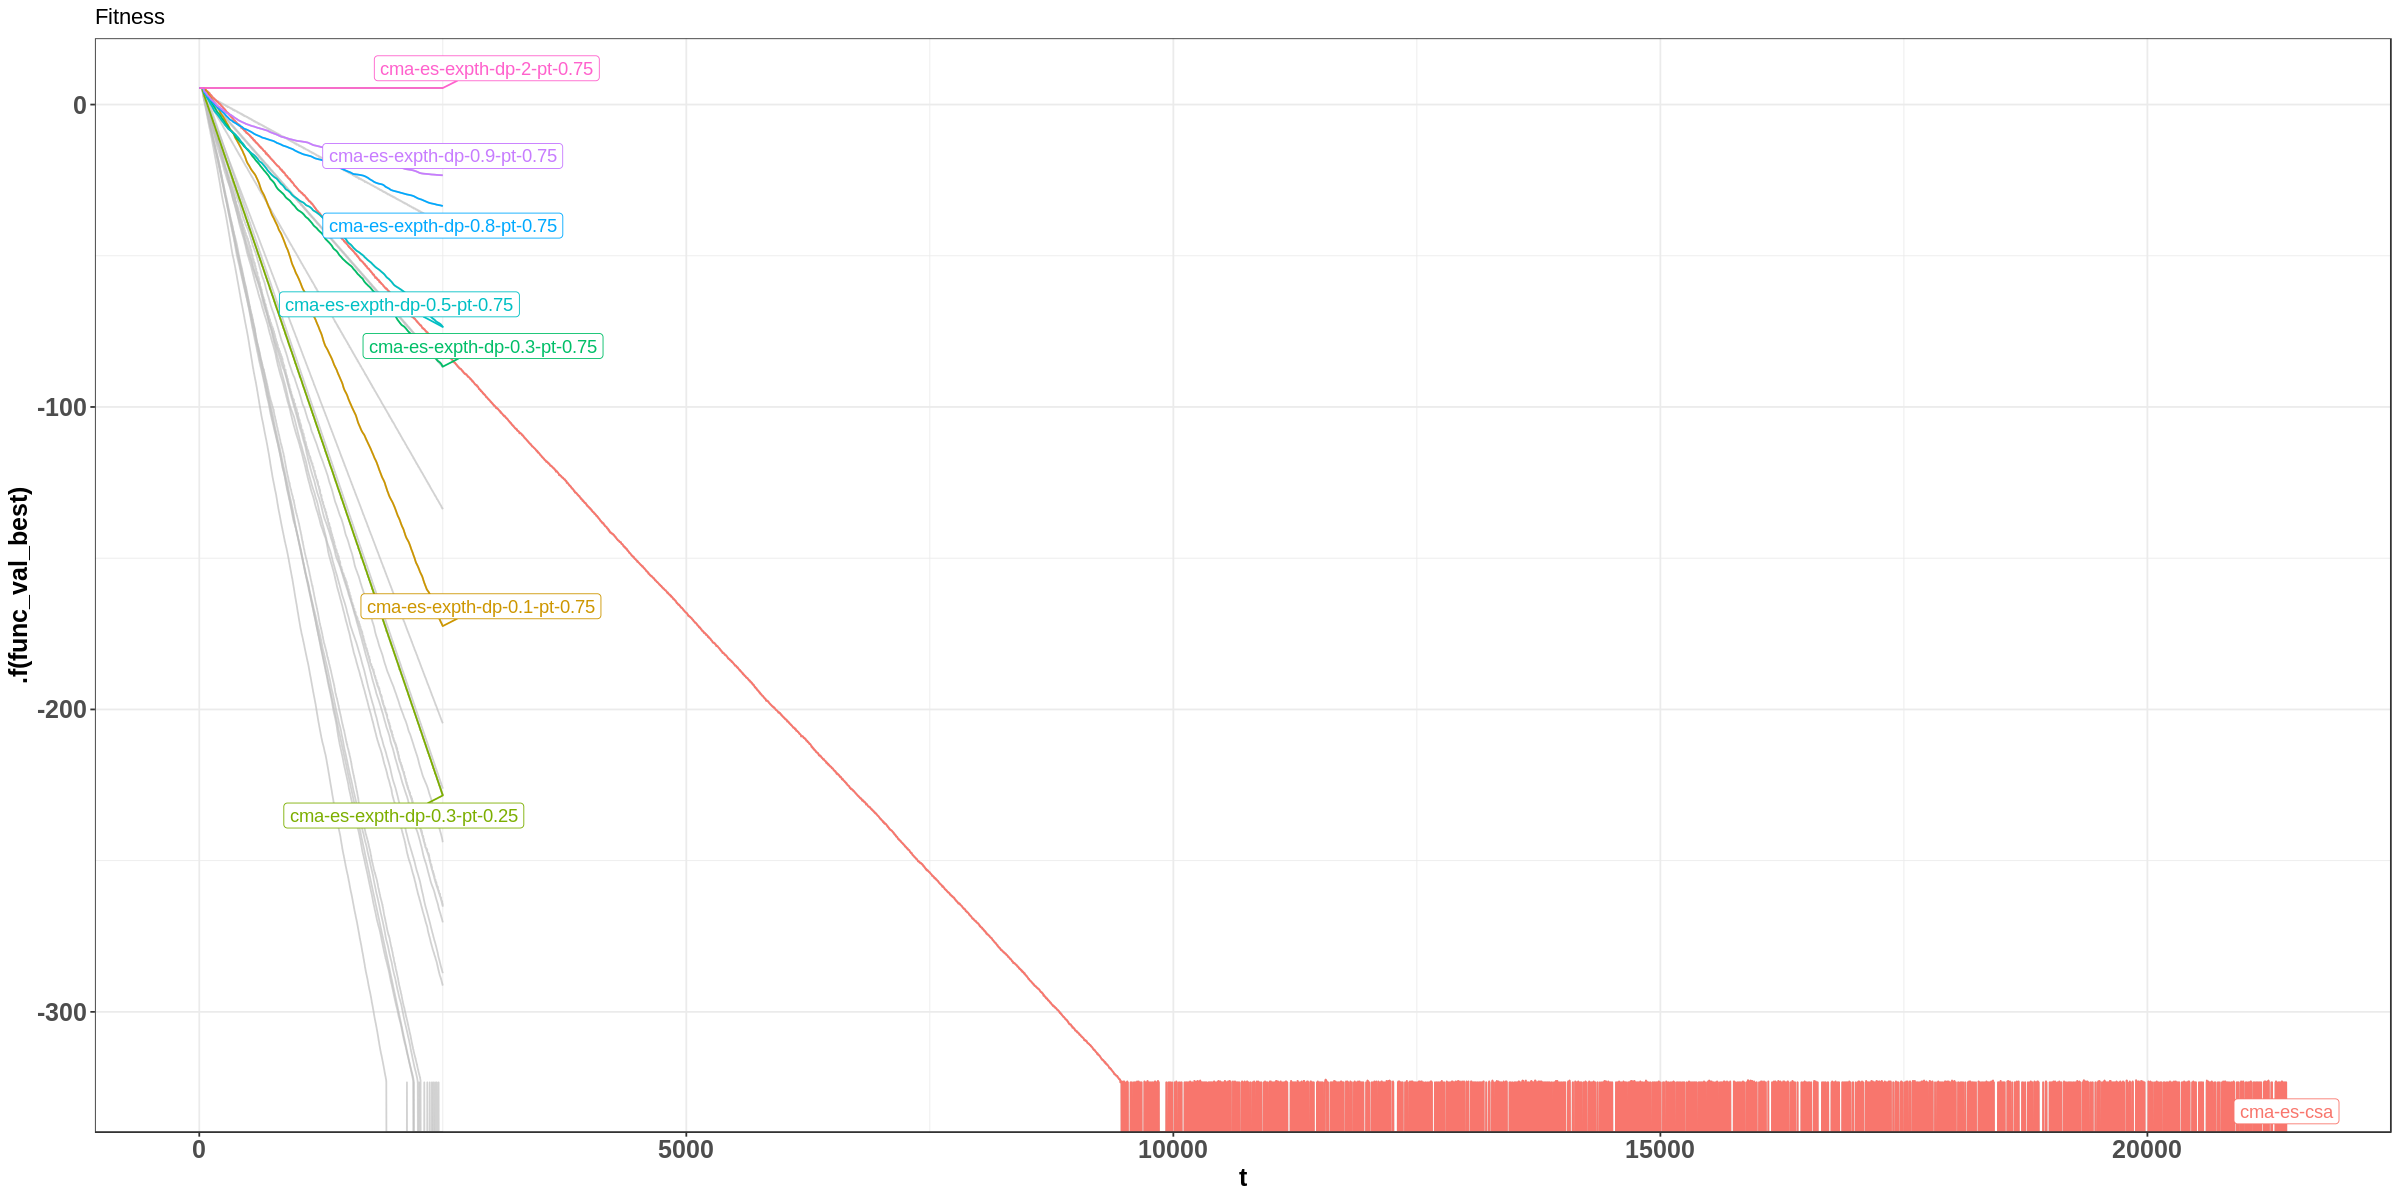

In [111]:
experiments_d30 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-csa","cma-es-expth-dp-0.3-pt-0.25", "cma-es-expth-dp-0.1-pt-0.75", "cma-es-expth-dp-0.3-pt-0.75", "cma-es-expth-dp-0.5-pt-0.75", "cma-es-expth-dp-0.8-pt-0.75", "cma-es-expth-dp-0.9-pt-0.75", "cma-es-expth-dp-2-pt-0.75"), use_direct_label = T)

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


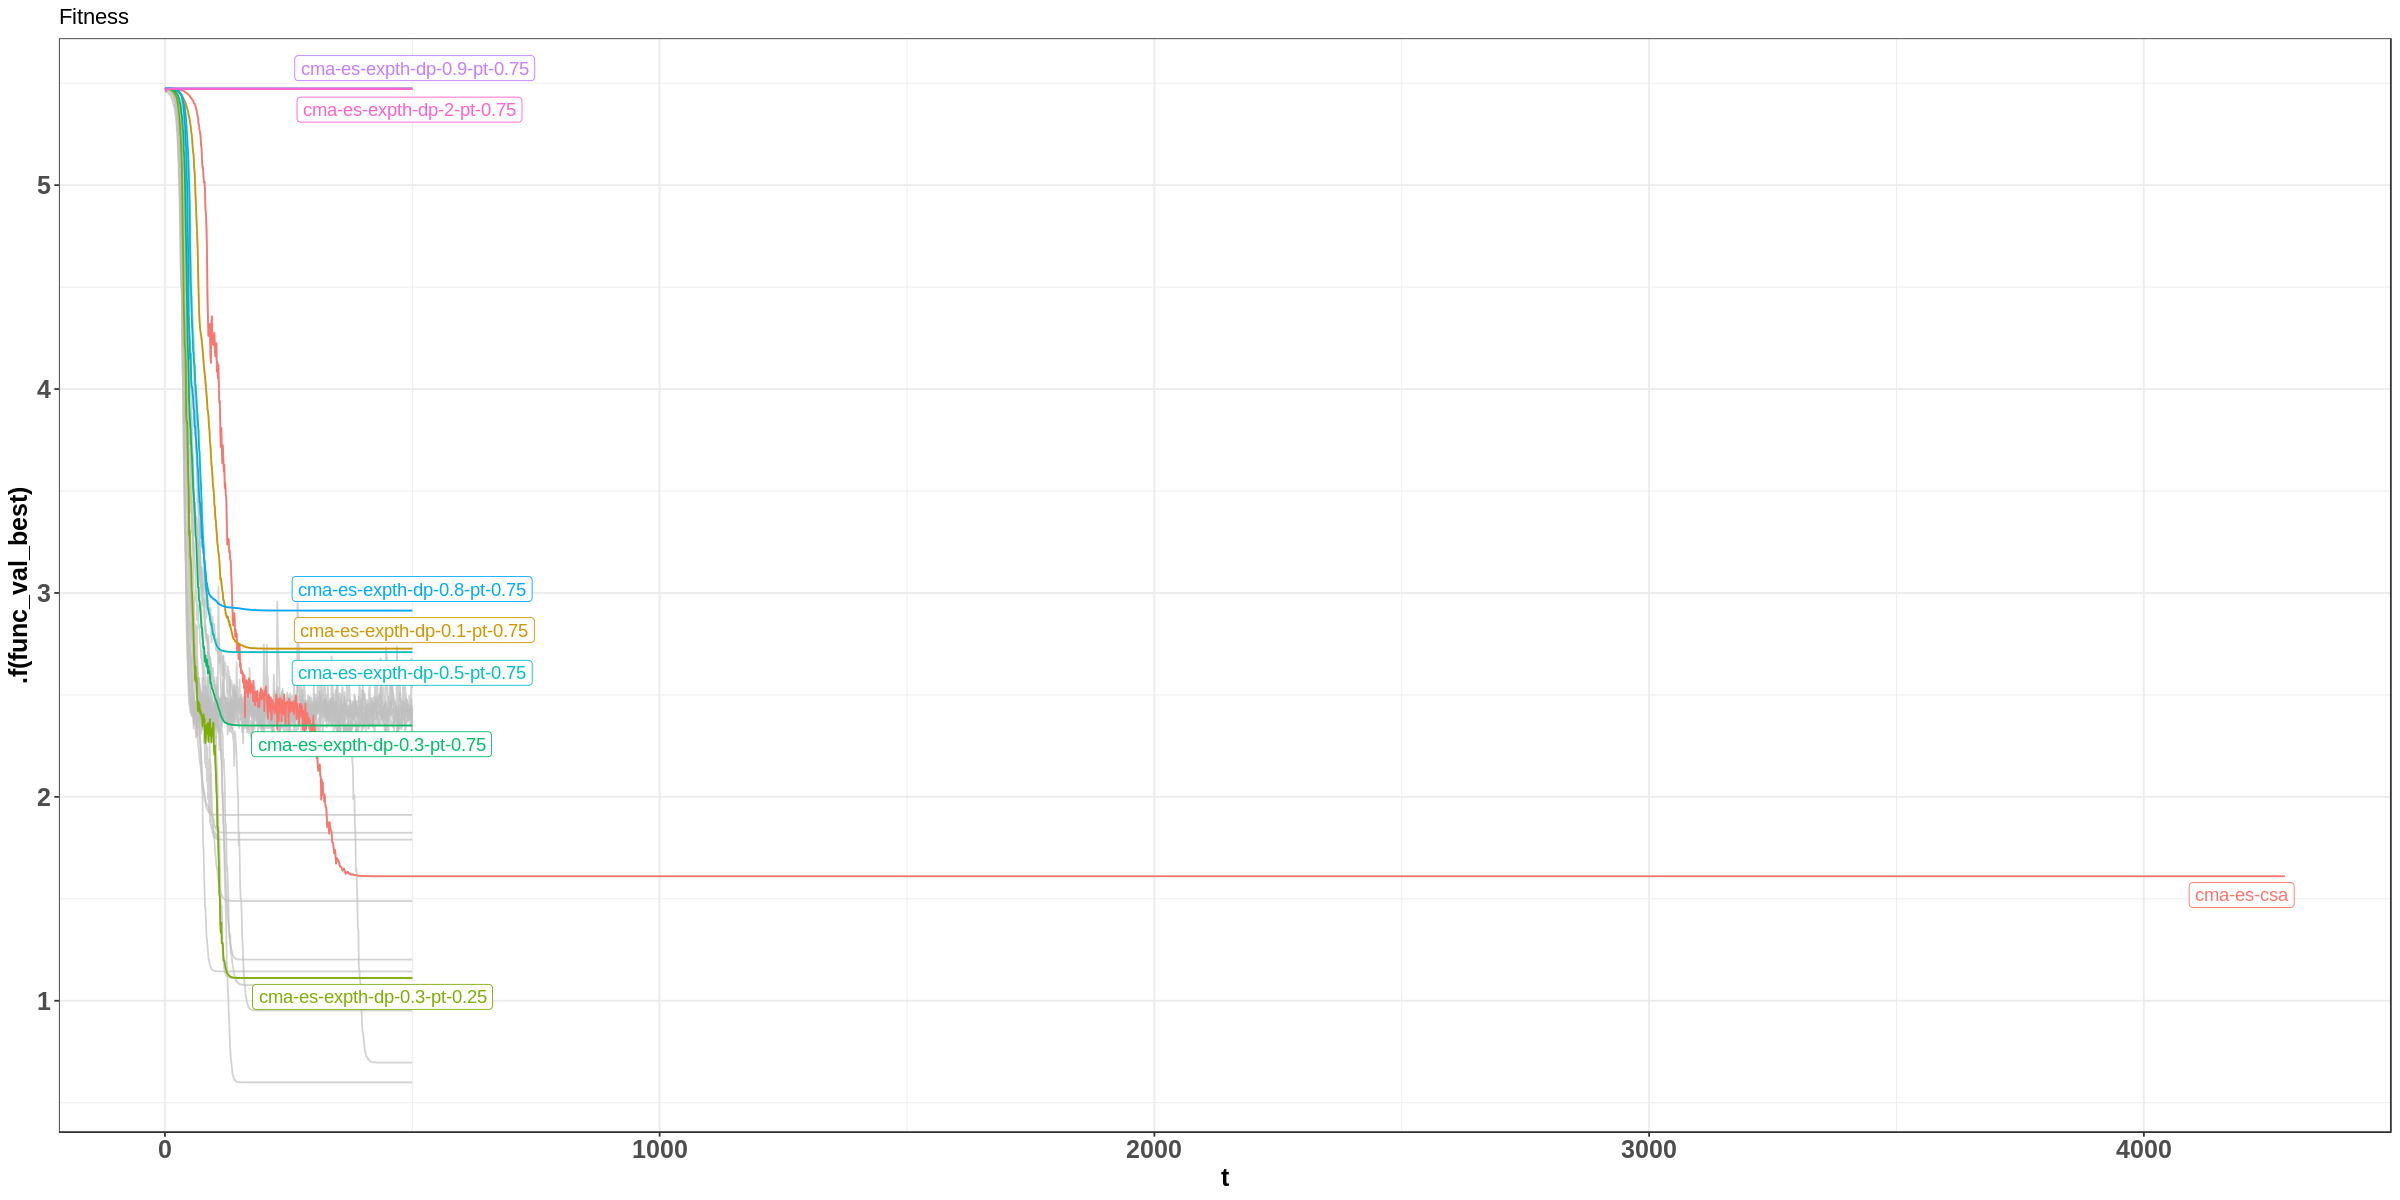

In [110]:
experiments_d30_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-csa", "cma-es-expth-dp-0.3-pt-0.25", "cma-es-expth-dp-0.1-pt-0.75", "cma-es-expth-dp-0.3-pt-0.75", "cma-es-expth-dp-0.5-pt-0.75", "cma-es-expth-dp-0.8-pt-0.75", "cma-es-expth-dp-0.9-pt-0.75", "cma-es-expth-dp-2-pt-0.75"), use_direct_label = T) 

## const P_target = 0.1 & Func = sphere & Rastrigin
### D_param in (0.1, 0.3, 0.5, 0.8, 0.9, 2)

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


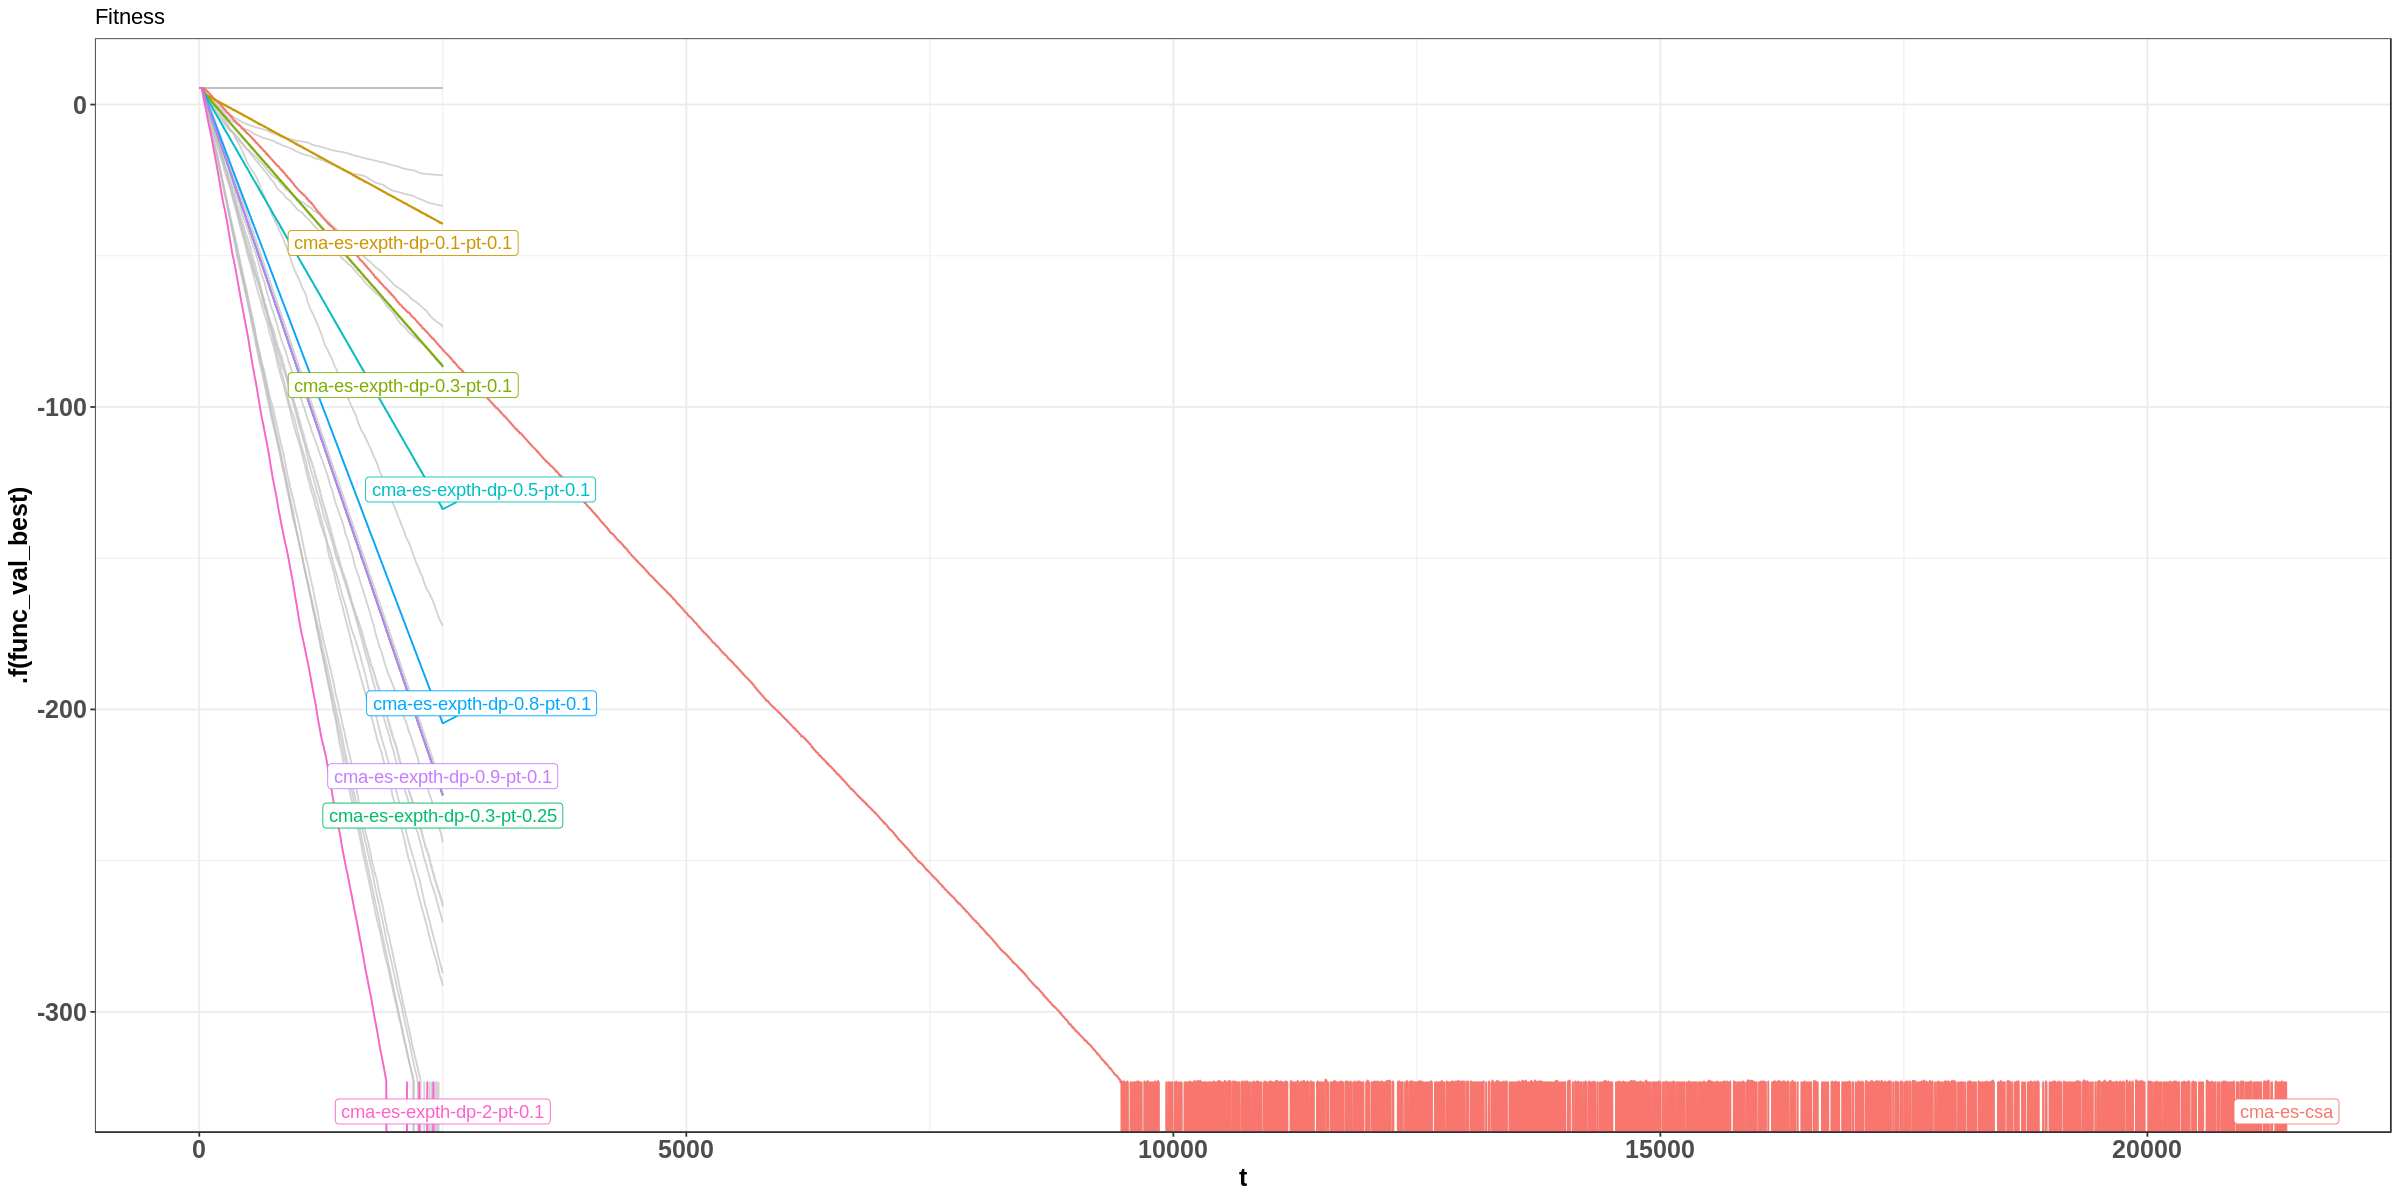

In [112]:
experiments_d30 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-csa", "cma-es-expth-dp-0.3-pt-0.25", "cma-es-expth-dp-0.1-pt-0.1", "cma-es-expth-dp-0.3-pt-0.1", "cma-es-expth-dp-0.5-pt-0.1", "cma-es-expth-dp-0.8-pt-0.1", "cma-es-expth-dp-0.9-pt-0.1", "cma-es-expth-dp-2-pt-0.1"), use_direct_label = T) 

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


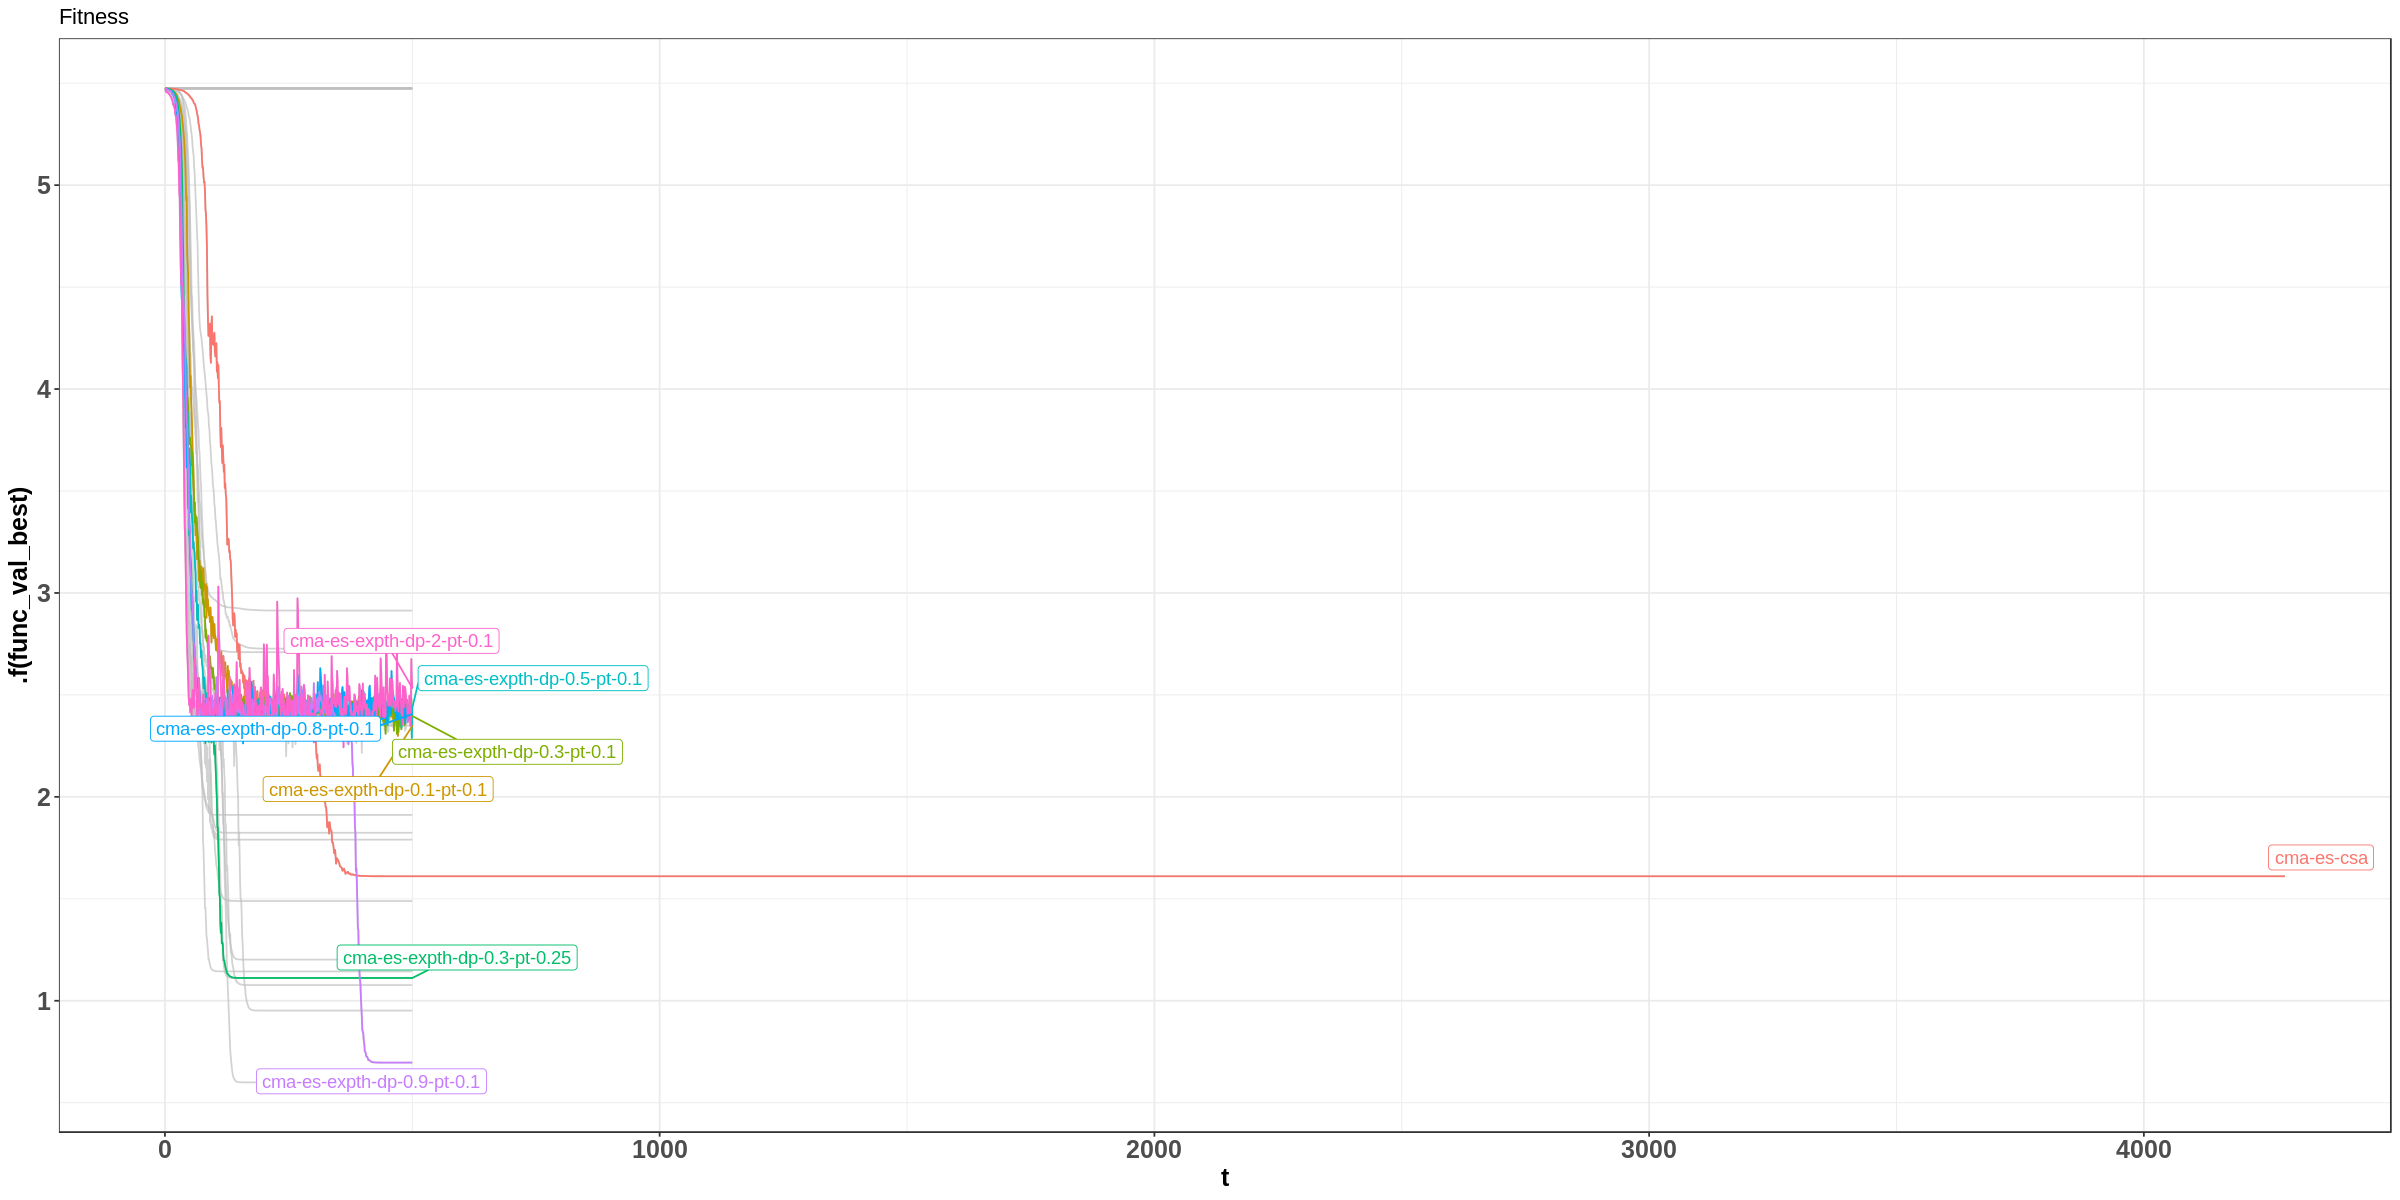

In [113]:
experiments_d30_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-csa", "cma-es-expth-dp-0.3-pt-0.25", "cma-es-expth-dp-0.1-pt-0.1", "cma-es-expth-dp-0.3-pt-0.1", "cma-es-expth-dp-0.5-pt-0.1", "cma-es-expth-dp-0.8-pt-0.1", "cma-es-expth-dp-0.9-pt-0.1", "cma-es-expth-dp-2-pt-0.1"), use_direct_label = T) 